In [1]:
import sys
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# ÌòÑÏû¨ ÎÖ∏Ìä∏Î∂Å ÌååÏùºÏùò Í≤ΩÎ°úÎ•º Í∏∞Ï§ÄÏúºÎ°ú ÌîÑÎ°úÏ†ùÌä∏ Î£®Ìä∏ Í≤ΩÎ°úÎ•º Í≥ÑÏÇ∞
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))

# sys.pathÏóê ÌîÑÎ°úÏ†ùÌä∏ Î£®Ìä∏ Í≤ΩÎ°úÍ∞Ä ÏóÜÏúºÎ©¥ Ï∂îÍ∞Ä
if project_root not in sys.path:
  sys.path.append(project_root)


In [2]:
from src.data.db_handler import DBHandler

db_handler = DBHandler(db_name="data_warehouse")

df_basic_info = db_handler.fetch_data(table_name="kr_stock_basic_info")
df_price_basic = db_handler.fetch_data(table_name="kr_stock_price_basic")
df_price_detail = db_handler.fetch_data(table_name="kr_stock_price_detail")
df_asking_price = db_handler.fetch_data(table_name="kr_stock_asking_price")


In [3]:
# ÌÖåÏù¥Î∏î Ïö∞ÏÑ†ÏàúÏúÑ
priority_order = [
  'df_basic_info',
  'df_price_basic',
  'df_asking_price',
  'df_price_detail'
]

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ
dataframes = {
  'df_basic_info' : df_basic_info,
  'df_price_basic' : df_price_basic,
  'df_price_detail' : df_price_detail,
  'df_asking_price' : df_asking_price,
}

key_cols = ['ticker']

# ÏµúÏ¢Ö Î≥ëÌï©Ïóê ÏÇ¨Ïö©Îê†, Ïª¨ÎüºÏù¥ Ï†ïÎ¶¨Îêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÎì§ÏùÑ Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
deduplicated_dataframes = {}
# Ïù¥ÎØ∏ ÏÑ†ÌÉùÎêú Ïª¨Îüº
seen_columns = set()

# 2. Ïö∞ÏÑ†ÏàúÏúÑ ÏàúÏÑúÎåÄÎ°ú ÏàúÌöåÌï©ÎãàÎã§.
for name in priority_order:
  df = dataframes[name]
  
  # ÌòÑÏû¨ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóêÏÑú tickerÎ•º Ï†úÏô∏ÌïòÍ≥† ÏïÑÏßÅ Î≥¥ÏßÄ Î™ªÌïú ÏÉàÎ°úÏö¥ Ïª¨ÎüºÎßå ÏÑ†ÌÉù
  cols = [col for col in df.columns if (col not in seen_columns) or (col in key_cols)]
  
  # ÏÑ†ÌÉùÎêú Ïª¨ÎüºÎì§Î°ú ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ ÎßåÎì§Ïñ¥ Ï†ÄÏû•
  deduplicated_dataframes[name] = df[cols]
  #print(f"[{name}]ÏóêÏÑú Í≥†Ïú† Ïª¨Îüº {len(cols)}Í∞úÎ•º ÏÑ†ÌÉùÌñàÏäµÎãàÎã§. (Ï§ëÎ≥µ Ï†úÍ±∞ : {len(df.columns.to_list())-len(cols)})")
  print(f'Select features in {name:<15} | cols : {len(cols):>2} | drop duplicated cols : {len(df.columns.to_list())-len(cols)}')

  # 'seen_columns' ÏÑ∏Ìä∏Ïóê Î∞©Í∏à Ï∂îÍ∞ÄÌïú Ïª¨ÎüºÎì§ÏùÑ ÏóÖÎç∞Ïù¥Ìä∏
  seen_columns.update(cols)

# ÏàòÏ†ïÎêú Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏùÑ Îã§Ïãú Î≥ÄÏàòÏóê Ìï†ÎãπÌï† Ïàò ÏûàÏäµÎãàÎã§.
df_basic_info = deduplicated_dataframes['df_basic_info']
df_price_basic = deduplicated_dataframes['df_price_basic']
df_price_detail = deduplicated_dataframes['df_price_detail']
df_asking_price = deduplicated_dataframes['df_asking_price']

Select features in df_basic_info   | cols : 21 | drop duplicated cols : 0
Select features in df_price_basic  | cols : 68 | drop duplicated cols : 0
Select features in df_asking_price | cols : 46 | drop duplicated cols : 0
Select features in df_price_detail | cols : 14 | drop duplicated cols : 18


In [4]:
df = df_basic_info.copy()
table = 'df_basic_info'
print(f'kr_stock_static_data : merged {table:<15} | rows: {df.shape[0]}, cols: {df.shape[1]}')

for table in priority_order[1:]:
  df = pd.merge(
    df,
    deduplicated_dataframes[table],
    on='ticker',
    how='left'
  )
  print(f'kr_stock_static_data : merged {table:<15} | rows: {df.shape[0]}, cols: {df.shape[1]}')


kr_stock_static_data : merged df_basic_info   | rows: 200, cols: 21
kr_stock_static_data : merged df_price_basic  | rows: 200, cols: 88
kr_stock_static_data : merged df_asking_price | rows: 200, cols: 133
kr_stock_static_data : merged df_price_detail | rows: 200, cols: 146


In [5]:
ROW, COL = df.shape[0], df.shape[1]

df_cols = df.columns.to_list()
columns_info = pd.DataFrame(columns=df_cols)

df.head()

ticker   lstg_stqt           cpta  papr scts_mket_lstg_dt idx_bztp_lcls_cd  \
0  005930  5919637922   778046685000   100        1975-06-11              002   
1  000660   728002365  3657652050000  5000        1996-12-26              002   
2  373220   234000000   117000000000   500        2022-01-27             None   
3  207940    71174000   177935000000  2500        2016-11-10             None   
4  012450    51563401   270317005000  5000        1987-05-27              002   

  idx_bztp_mcls_cd idx_bztp_scls_cd     prdt_name prdt_abrv_name  \
0              013              013       ÏÇºÏÑ±Ï†ÑÏûêÎ≥¥ÌÜµÏ£º           ÏÇºÏÑ±Ï†ÑÏûê   
1              013              013   ÏóêÏä§ÏºÄÏù¥ÌïòÏù¥ÎãâÏä§Î≥¥ÌÜµÏ£º         SKÌïòÏù¥ÎãâÏä§   
2             None             None   LGÏóêÎÑàÏßÄÏÜîÎ£®ÏÖòÎ≥¥ÌÜµÏ£º       LGÏóêÎÑàÏßÄÏÜîÎ£®ÏÖò   
3             None             None   ÏÇºÏÑ±Î∞îÏù¥Ïò§Î°úÏßÅÏä§Î≥¥ÌÜµÏ£º       ÏÇºÏÑ±Î∞îÏù¥Ïò§Î°úÏßÅÏä§   
4              014              014  ÌïúÌôîÏóêÏñ¥Î°úÏä§ÌéòÏù¥Ïä§Î≥¥ÌÜµÏ£º      ÌïúÌôîÏóêÏñ¥Î°úÏä§ÌéòÏù¥Ïä§   

       std_pdno  sbst_pric  thdt_clpr  bfdy_clpr std_idst_clsf_cd  \
0  KR7005930003      60570      79700      79700           032604   
1  KR7000660001     254160     353000     353000           032601   
2  KR7373220003     265620     349500     349500           032802   
3  KR7207940008     798720    1024000    1024000           032101   
4  KR7012450003     654080    1022000    1022000           033103   

   std_idst_clsf_cd_name idx_bztp_lcls_cd_name idx_bztp_mcls_cd_name  \
0         ÌÜµÏã† Î∞è Î∞©ÏÜ° Ïû•ÎπÑ Ï†úÏ°∞ÏóÖ               ÏãúÍ∞ÄÏ¥ùÏï°Í∑úÎ™®ÎåÄ                 Ï†ÑÍ∏∞,Ï†ÑÏûê   
1                Î∞òÎèÑÏ≤¥ Ï†úÏ°∞ÏóÖ               ÏãúÍ∞ÄÏ¥ùÏï°Í∑úÎ™®ÎåÄ                 Ï†ÑÍ∏∞,Ï†ÑÏûê   
2         ÏùºÏ∞®Ï†ÑÏßÄ Î∞è Ï∂ïÏ†ÑÏßÄ Ï†úÏ°∞ÏóÖ                  None                  None   
3  Í∏∞Ï¥à ÏùòÏïΩÎ¨ºÏßà Î∞è ÏÉùÎ¨ºÌïôÏ†Å Ï†úÏ†ú Ï†úÏ°∞ÏóÖ                  None                  None   
4       Ìï≠Í≥µÍ∏∞,Ïö∞Ï£ºÏÑ† Î∞è Î∂ÄÌíà Ï†úÏ°∞ÏóÖ               ÏãúÍ∞ÄÏ¥ùÏï°Í∑úÎ™®ÎåÄ                  ÏùòÎ£åÏ†ïÎ∞Ä   

  idx_bztp_scls_cd_name issu_istt_cd  frnr_psnl_lmt_rt iscd_stat_cls_code  \
0                 Ï†ÑÍ∏∞,Ï†ÑÏûê        00593               0.0                 55   
1                 Ï†ÑÍ∏∞,Ï†ÑÏûê        00066               0.0                 55   
2                  None        37322               0.0                 55   
3                  None        20794               0.0                 55   
4                  ÏùòÎ£åÏ†ïÎ∞Ä        01245               0.0                 55   

   marg_rate new_hgpr_lwpr_cls_code bstp_kor_isnm  crdt_able_yn  \
0       20.0                    Ïã†Í≥†Í∞Ä         Ï†ÑÍ∏∞¬∑Ï†ÑÏûê          True   
1       20.0                    Ïã†Í≥†Í∞Ä         Ï†ÑÍ∏∞¬∑Ï†ÑÏûê          True   
2       20.0                    NaN         Ï†ÑÍ∏∞¬∑Ï†ÑÏûê          True   
3       20.0                    NaN            Ï†úÏïΩ          True   
4       20.0                    NaN       Ïö¥ÏÜ°Ïû•ÎπÑ¬∑Î∂ÄÌíà          True   

  grmn_rate_cls_code  elw_pblc_yn  stck_prpr  prdy_vrss prdy_vrss_sign  \
0                 40         True      79700     -800.0              5   
1                 40         True     353000        NaN              3   
2                 40         True     349500    -5000.0              5   
3                 40         True    1024000    -5000.0              5   
4                 40         True    1022000    -1000.0              5   

   prdy_ctrt   acml_tr_pbmn  acml_vol  prdy_vrss_vol_rate  stck_oprc  \
0      -0.99  1672547819584  20898386               81.57      81100   
1       0.00  1546050743059   4385543               96.89     351500   
2      -1.41    64980756750    185906              106.97     351500   
3      -0.49    93367438000     91201              177.89    1023000   
4      -0.10   372660454884    363904              173.56    1010000   

   stck_hgpr  stck_lwpr  stck_mxpr  stck_llam  stck_sdpr  wghn_avrg_stck_prc  \
0      81200     

In [6]:
df = df.copy()

df[df_cols] = df[df_cols].replace(r'^\s*$', np.nan, regex=True)
df[df_cols] = df[df_cols].replace(['0', 0], np.nan)

In [7]:
# Í≤∞Ï∏°Í∞í Í∞úÏàò/ÎπÑÏú® ÏÇ∞Ï∂ú Î∞è Ï†úÍ±∞ Î¶¨Ïä§Ìä∏
missing_count = df[df_cols].isnull().sum()
missing_percent = ((missing_count / ROW) * 100).round(2)

# --- 3. Í≤∞Í≥º Ï∑®Ìï© Î∞è Ï∂úÎ†• ---
missing_df = pd.DataFrame({
  'missing_count': missing_count,
  'missing_percent': missing_percent
})

columns_info.loc['missing_count'] = missing_df['missing_count']
columns_info.loc['missing_percent'] = missing_df['missing_percent']

columns_info

ticker  lstg_stqt  cpta  papr  scts_mket_lstg_dt  \
missing_count       0.0        0.0   0.0   0.0                0.0   
missing_percent     0.0        0.0   0.0   0.0                0.0   

                 idx_bztp_lcls_cd  idx_bztp_mcls_cd  idx_bztp_scls_cd  \
missing_count                49.0              62.0              62.0   
missing_percent              24.5              31.0              31.0   

                 prdt_name  prdt_abrv_name  std_pdno  sbst_pric  thdt_clpr  \
missing_count          0.0             0.0       0.0        0.0        0.0   
missing_percent        0.0             0.0       0.0        0.0        0.0   

                 bfdy_clpr  std_idst_clsf_cd  std_idst_clsf_cd_name  \
missing_count          0.0               0.0                    0.0   
missing_percent        0.0               0.0                    0.0   

                 idx_bztp_lcls_cd_name  idx_bztp_mcls_cd_name  \
missing_count                     50.0                   68.0   
missing_percent                   25.0                   34.0   

                 idx_bztp_scls_cd_name  issu_istt_cd  frnr_psnl_lmt_rt  \
missing_count                     74.0           0.0             198.0   
missing_percent                   37.0           0.0              99.0   

                 iscd_stat_cls_code  marg_rate  new_hgpr_lwpr_cls_code  \
missing_count                   0.0        0.0                     0.0   
missing_percent                 0.0        0.0                     0.0   

                 bstp_kor_isnm  crdt_able_yn  grmn_rate_cls_code  elw_pblc_yn  \
missing_count              0.0           0.0                11.0          0.0   
missing_percent            0.0           0.0                 5.5          0.0   

                 stck_prpr  prdy_vrss  prdy_vrss_sign  prdy_ctrt  \
missing_count          0.0        8.0             0.0        8.0   
missing_percent        0.0        4.0             0.0        4.0   

                 acml_tr_pbmn  acml_vol  prdy_vrss_vol_rate  stck_oprc  \
missing_count             0.0       0.0                 0.0        0.0   
missing_percent           0.0       0.0                 0.0        0.0   

                 stck_hgpr  stck_lwpr  stck_mxpr  stck_llam  stck_sdpr  \
missing_count          0.0        0.0        0.0        0.0        0.0   
missing_percent        0.0        0.0        0.0        0.0        0.0   

                 wghn_avrg_stck_prc  hts_frgn_ehrt  frgn_ntby_qty  \
missing_count                   0.0            0.0            1.0   
missing_percent                 0.0            0.0            0.5   

                 pgtr_ntby_qty  pvt_scnd_dmrs_prc  pvt_frst_dmrs_prc  \
missing_count              0.0                0.0                0.0   
missing_percent            0.0                0.0                0.0   

                 pvt_pont_val  pvt_frst_dmsp_prc  pvt_scnd_dmsp_prc  dmrs_val  \
missing_count             0.0                0.0                0.0       0.0   
missing_percent           0.0                0.0                0.0       0.0   

                 dmsp_val  cpfn  rstc_wdth_prc  stck_fcam  stck_sspr  \
missing_count         0.0   0.0            0.0        0.0        0.0   
missing_percent       0.0   0.0            0.0        0.0        0.0   

                 aspr_unit  lstn_stcn  hts_avls  per  pbr  vol_tnrt  eps  bps  \
missing_count          0.0        0.0       0.0  0.0  0.0       0.0  0.0  0.0   
missing_percent        0.0        0.0       0.0  0.0  0.0       0.0  0.0  0.0   

                 d250_hgpr  d250_hgpr_date  d250_hgpr_vrss_prpr_rate  \
missing_count          0.0             0.0                       4.0   
missing_percent        0.0             0.0                       2.0   

                 d250_lwpr  d250_lwpr_date  d250_lwpr_vrss_prpr_rate  \
missing_count          0.0             0.0                       0.0   
missing_percent        0.0             0.0                       0.0   

                 stck_dryy_hgpr  dryy_h

In [8]:
# Ï§ëÎ≥µÍ∞í Í∞úÏàò/ÎπÑÏú® ÏÇ∞Ï∂ú Î∞è Ï†úÍ±∞ Î¶¨Ïä§Ìä∏ ÏÑ§Ï†ï
unique_count = df[df_cols].nunique()
unique_percent = ((unique_count / ROW) * 100).round(2)

# --- 3. Í≤∞Í≥º Ï∑®Ìï© Î∞è Ï∂úÎ†• ---
unique_df = pd.DataFrame({
  'unique_count': unique_count,
  'unique_percent': unique_percent
})

columns_info.loc['unique_count'] = unique_df['unique_count']
columns_info.loc['unique_percent'] = unique_df['unique_percent']

columns_info

ticker  lstg_stqt   cpta  papr  scts_mket_lstg_dt  \
missing_count       0.0        0.0    0.0   0.0                0.0   
missing_percent     0.0        0.0    0.0   0.0                0.0   
unique_count      200.0      200.0  200.0   6.0              187.0   
unique_percent    100.0      100.0  100.0   3.0               93.5   

                 idx_bztp_lcls_cd  idx_bztp_mcls_cd  idx_bztp_scls_cd  \
missing_count                49.0              62.0              62.0   
missing_percent              24.5              31.0              31.0   
unique_count                  5.0              26.0              29.0   
unique_percent                2.5              13.0              14.5   

                 prdt_name  prdt_abrv_name  std_pdno  sbst_pric  thdt_clpr  \
missing_count          0.0             0.0       0.0        0.0        0.0   
missing_percent        0.0             0.0       0.0        0.0        0.0   
unique_count         200.0           200.0     200.0      199.0      190.0   
unique_percent       100.0           100.0     100.0       99.5       95.0   

                 bfdy_clpr  std_idst_clsf_cd  std_idst_clsf_cd_name  \
missing_count          0.0               0.0                    0.0   
missing_percent        0.0               0.0                    0.0   
unique_count         190.0              67.0                   67.0   
unique_percent        95.0              33.5                   33.5   

                 idx_bztp_lcls_cd_name  idx_bztp_mcls_cd_name  \
missing_count                     50.0                   68.0   
missing_percent                   25.0                   34.0   
unique_count                       4.0                   21.0   
unique_percent                     2.0                   10.5   

                 idx_bztp_scls_cd_name  issu_istt_cd  frnr_psnl_lmt_rt  \
missing_count                     74.0           0.0             198.0   
missing_percent                   37.0           0.0              99.0   
unique_count                      18.0         200.0               2.0   
unique_percent                     9.0         100.0               1.0   

                 iscd_stat_cls_code  marg_rate  new_hgpr_lwpr_cls_code  \
missing_count                   0.0        0.0                     0.0   
missing_percent                 0.0        0.0                     0.0   
unique_count                    2.0        6.0                     2.0   
unique_percent                  1.0        3.0                     1.0   

                 bstp_kor_isnm  crdt_able_yn  grmn_rate_cls_code  elw_pblc_yn  \
missing_count              0.0           0.0                11.0          0.0   
missing_percent            0.0           0.0                 5.5          0.0   
unique_count              21.0           1.0                 3.0          1.0   
unique_percent            10.5           0.5                 1.5          0.5   

                 stck_prpr  prdy_vrss  prdy_vrss_sign  prdy_ctrt  \
missing_count          0.0        8.0             0.0        8.0   
missing_percent        0.0        4.0             0.0        4.0   
unique_count         190.0      108.0             3.0      165.0   
unique_percent        95.0       54.0             1.5       82.5   

                 acml_tr_pbmn  acml_vol  prdy_vrss_vol_rate  stck_oprc  \
missing_count             0.0       0.0                 0.0        0.0   
missing_percent           0.0       0.0                 0.0        0.0   
unique_count            200.0     200.0               200.0      187.0   
unique_percent          100.0     100.0               100.0       93.5   

                 stck_hgpr  stck_lwpr  stck_mxpr  stck_llam  stck_sdpr  \
missing_count          0.0        0.0        0.0        0.0        0.0   
missing_percent        0.0        0.0        0.0        0.0        0.0   
unique_count         197.0      190.0      195.0      191.0      195.0   
unique_percent        98.5       95.0       97.5       95.5       97.5 

In [9]:
MISSING_PERCENT_THRESHOLD = 50.0
UNIQUE_COUNT_THRESHOLD = 1

# --- 2. Identify Columns to Drop ---
missing_info = columns_info.loc['missing_percent']
unique_info = columns_info.loc['unique_count']

# Ï†úÍ±∞Ìï† Ïª¨ÎüºÍ≥º Í∑∏ Ïù¥Ïú†(Í∞í)Î•º Ìï®Íªò Ï†ÄÏû•
drop_missing_cols = {
  col: val for col, val in missing_info.items() 
  if val > MISSING_PERCENT_THRESHOLD
}
drop_unique_cols = {
  col: val for col, val in unique_info.items() 
  if val <= UNIQUE_COUNT_THRESHOLD
}

# ÏµúÏ¢Ö Ï†úÍ±∞ Î™©Î°ù ÏÉùÏÑ±
total_drop_cols = sorted(list(set(drop_missing_cols.keys()) | set(drop_unique_cols.keys())))

# --- 3. Logging and Execution ---
print("="*80)
print("Step: Feature Selection based on Data Quality".center(80))
print("="*80)

# [INFO] Initial DataFrame shape: Ï∂úÎ†•
left_str = "[INFO] Initial DataFrame shape:"
right_str = str(df.shape)
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

# [INFO] Thresholds: Ï∂úÎ†• (ÏÇ¨Ïö©Ïûê ÏöîÏ≤≠ ÏµúÏ¢Ö Ìè¨Îß∑ Ï†ÅÏö©)
left_str = "[INFO] Thresholds"
# --- Missing % ÎùºÏù∏ ---
right_str = f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%"
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

# --- Unique Count ÎùºÏù∏ ---
right_str = f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}"
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

print("-"*80)


if total_drop_cols:
  df_cleaned = df.drop(columns=total_drop_cols)
  
  print("[ACTION] Dropping columns...")
  
  if drop_missing_cols:
    header_text = f" Reason: High Missing Value Ratio ({len(drop_missing_cols)} columns) "
    print(f"\n{header_text.center(80, '-')}")
    for col, val in drop_missing_cols.items():
      left_str = f"- Dropping {col}"
      right_str = f"(Missing: {val:.2f}%)"
      padding = 80 - len(right_str)
      print(f"{left_str:<{padding}}{right_str}")
          
  if drop_unique_cols:
    header_text = f" Reason: Low Unique Value Count ({len(drop_unique_cols)} columns) "
    print(f"\n{header_text.center(80, '-')}")
    for col, val in drop_unique_cols.items():
      left_str = f"- Dropping {col}"
      right_str = f"(Unique Count: {int(val)})"
      padding = 80 - len(right_str)
      print(f"{left_str:<{padding}}{right_str}")

  print("\n" + "-"*80)
  print(f"[SUMMARY] Total {len(total_drop_cols)} columns dropped.")
  print(f"[SUMMARY] Cleaned DataFrame shape: {df_cleaned.shape}")

else:
  df_cleaned = df.copy()
  print("[SUMMARY] No columns to drop. DataFrame remains unchanged.")

print("="*80)


                 Step: Feature Selection based on Data Quality                  
[INFO] Initial DataFrame shape:                                       (200, 146)
[INFO] Thresholds                                        Missing Percent > 50.0%
[INFO] Thresholds                                           Unique Count <=    1
--------------------------------------------------------------------------------
[ACTION] Dropping columns...

----------------- Reason: High Missing Value Ratio (2 columns) -----------------
- Dropping frnr_psnl_lmt_rt                                    (Missing: 99.00%)
- Dropping fcam_cnnm                                           (Missing: 63.00%)

------------------ Reason: Low Unique Value Count (2 columns) ------------------
- Dropping crdt_able_yn                                        (Unique Count: 1)
- Dropping elw_pblc_yn                                         (Unique Count: 1)

-----------------------------------------------------------------------------

In [10]:
import pandas as pd
import numpy as np

# 1. ÏàòÏπòÌòï Ïª¨Îüº ÏÑ†ÌÉù
cleaned_numeric_cols = df_cleaned.select_dtypes(include=np.number).columns.tolist()

# 2. Î≤îÏ£ºÌòï Ïª¨Îüº ÏÑ†ÌÉù
cleaned_categorical_cols = df_cleaned.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

# 3. Datetime Ïª¨Îüº ÏÑ†ÌÉù (ÎàÑÎùΩÎêòÏóàÎçò Î∂ÄÎ∂Ñ)
cleaned_datetime_cols = df_cleaned.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# TickerÎäî ÏãùÎ≥ÑÏûêÏù¥ÎØÄÎ°ú Î∂ÑÏÑù Î¶¨Ïä§Ìä∏ÏóêÏÑú Ï†úÏô∏
# (Ïù¥ÎØ∏ ÏàòÌñâÌïòÏÖ®ÏßÄÎßå, ÏïàÏ†ÑÏùÑ ÏúÑÌï¥ Ìïú Î≤à Îçî ÌôïÏù∏)
if 'ticker' in cleaned_categorical_cols:
  cleaned_categorical_cols.remove('ticker') # tickerÎäî Î≥¥ÌÜµ category ÌÉÄÏûÖ

# --- Í≤∞Í≥º ÌôïÏù∏ ---
print(f"Ï¥ù {len(df_cleaned.columns)}Í∞úÏùò Ïª¨ÎüºÏù¥ 3Í∞úÏùò Í∑∏Î£πÏúºÎ°ú Î∂ÑÎ¶¨ÎêòÏóàÏäµÎãàÎã§.")
print("-" * 50)
print(f"ÏàòÏπòÌòï Ïª¨Îüº ({len(cleaned_numeric_cols)}Í∞ú)")
print(f"Î≤îÏ£ºÌòï Ïª¨Îüº ({len(cleaned_categorical_cols)}Í∞ú)")
print(f"Datetime Ïª¨Îüº ({len(cleaned_datetime_cols)}Í∞ú)")
print("-" * 50)

# ÏµúÏ¢Ö Í≤ÄÏ¶ù
total_classified = len(cleaned_numeric_cols) + len(cleaned_categorical_cols) + len(cleaned_datetime_cols)
print(f"Í≤ÄÏ¶ù: {total_classified + 1} (Î∂ÑÎ•òÎêú Ïª¨Îüº) == {len(df_cleaned.columns)} (Ï†ÑÏ≤¥ Ïª¨Îüº)")

Ï¥ù 142Í∞úÏùò Ïª¨ÎüºÏù¥ 3Í∞úÏùò Í∑∏Î£πÏúºÎ°ú Î∂ÑÎ¶¨ÎêòÏóàÏäµÎãàÎã§.
--------------------------------------------------
ÏàòÏπòÌòï Ïª¨Îüº (110Í∞ú)
Î≤îÏ£ºÌòï Ïª¨Îüº (24Í∞ú)
Datetime Ïª¨Îüº (7Í∞ú)
--------------------------------------------------
Í≤ÄÏ¶ù: 142 (Î∂ÑÎ•òÎêú Ïª¨Îüº) == 142 (Ï†ÑÏ≤¥ Ïª¨Îüº)


‚úÖ Ï¥ù 878Í∞úÏùò Î≥ÄÏàò ÏåçÏóêÏÑú ÏûÑÍ≥ÑÍ∞í(0.95)ÏùÑ Ï¥àÍ≥ºÌïòÎäî ÎÜíÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Î∞úÍ≤¨ÎêòÏóàÏäµÎãàÎã§.
üëâ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏùÄ Î≥ÄÏàò Í∞úÏàò: 61Í∞ú
üëâ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÇÆÏùÄ Î≥ÄÏàò Í∞úÏàò: 49Í∞ú


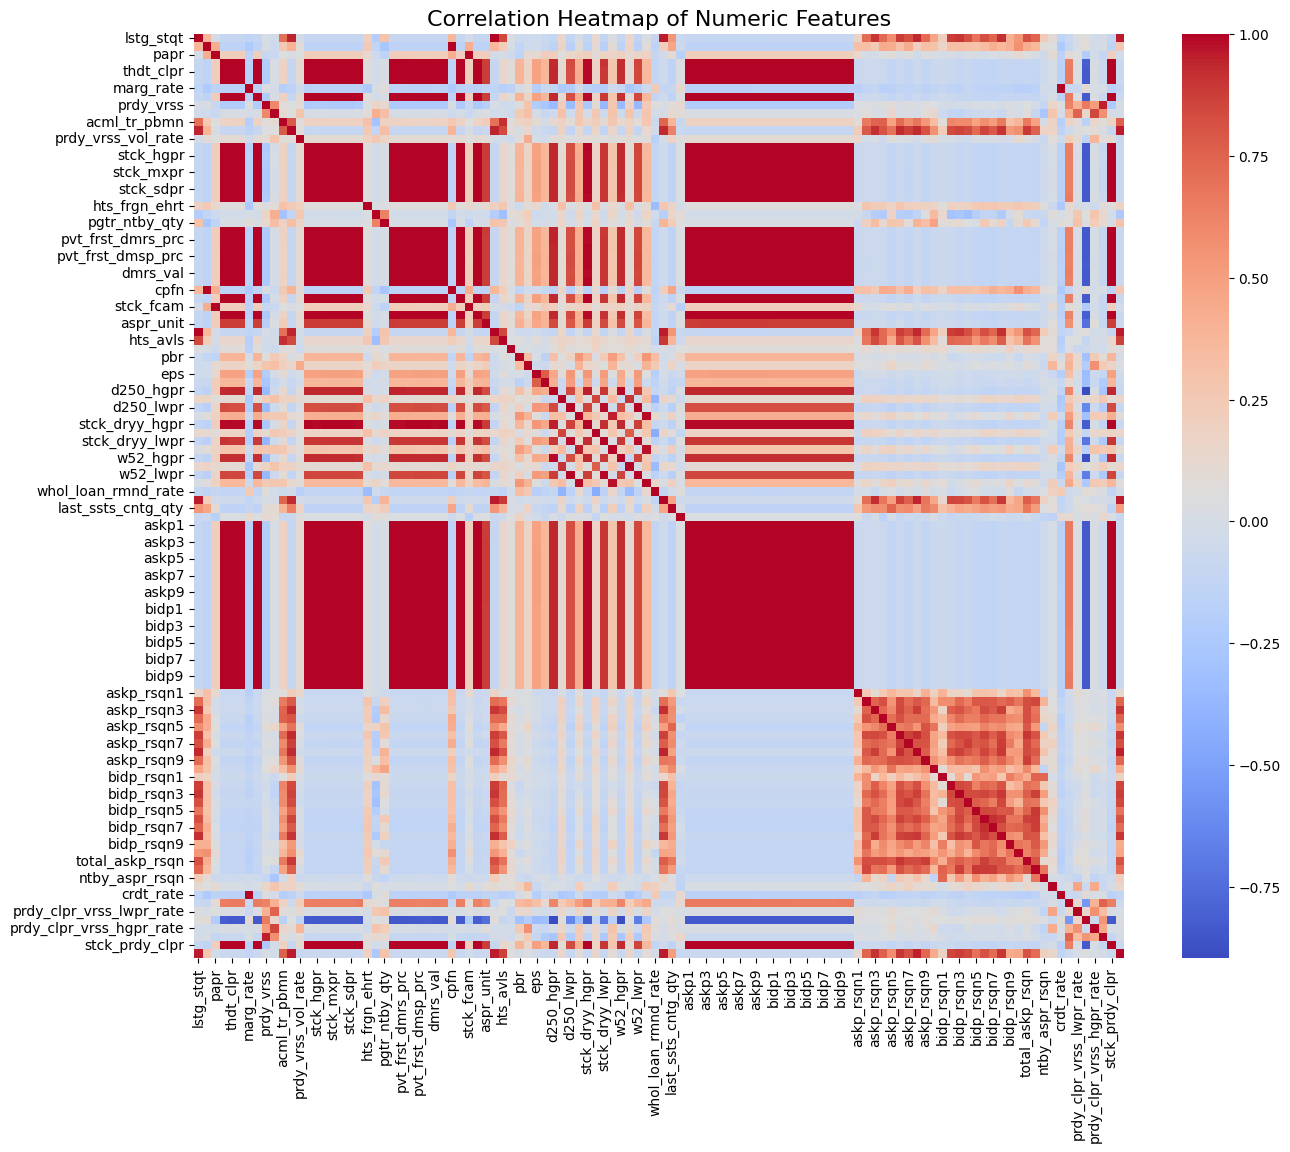

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌñâÎ†¨ Í≥ÑÏÇ∞ ---
numeric_df = df_cleaned[cleaned_numeric_cols]
corr_matrix = numeric_df.corr(method='pearson')

# --- Step 2: ÎÜíÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Í∞ÄÏßÑ Î≥ÄÏàò Ïåç ÏûêÎèô Ï∂îÏ∂ú ---
THRESHHOLD = 0.95
num_high_corr_pairs = []

# Ï§ëÎ≥µÏùÑ ÌîºÌïòÍ∏∞ ÏúÑÌï¥ ÏÉÅÍ¥Ä ÌñâÎ†¨Ïùò ÏÉÅÏÇºÍ∞ÅÌñâÎ†¨(upper triangle)Îßå ÏàúÌöå
for i in range(len(corr_matrix.columns)):
  for j in range(i):
    if abs(corr_matrix.iloc[i, j]) > THRESHHOLD:
      pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
      num_high_corr_pairs.append(pair)

# ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÏàúÏúºÎ°ú Ï†ïÎ†¨
num_high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"‚úÖ Ï¥ù {len(num_high_corr_pairs)}Í∞úÏùò Î≥ÄÏàò ÏåçÏóêÏÑú ÏûÑÍ≥ÑÍ∞í({THRESHHOLD})ÏùÑ Ï¥àÍ≥ºÌïòÎäî ÎÜíÏùÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Î∞úÍ≤¨ÎêòÏóàÏäµÎãàÎã§.")

# --- Step 3: ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏùÄ Î≥ÄÏàòÏôÄ ÎÇÆÏùÄ Î≥ÄÏàò Î¶¨Ïä§Ìä∏ Î∂ÑÎ¶¨ ---

# ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏùÄ Î≥ÄÏàòÎì§Ïùò Ïù¥Î¶ÑÎßå Ï∂îÏ∂ú (Ï§ëÎ≥µ Ï†úÍ±∞Î•º ÏúÑÌï¥ set ÏÇ¨Ïö©)
# num_high_corr_pairs Î¶¨Ïä§Ìä∏Î•º ÏàúÌöåÌïòÎ©∞ Í∞Å ÌäúÌîåÏùò Ï≤´ Î≤àÏß∏, Îëê Î≤àÏß∏ ÏõêÏÜå(Î≥ÄÏàò Ïù¥Î¶Ñ)Î•º Î™®Îëê Í∞ÄÏ†∏ÏòµÎãàÎã§.
high_corr_cols_set = set()
for pair in num_high_corr_pairs:
  high_corr_cols_set.add(pair[0])
  high_corr_cols_set.add(pair[1])

high_corr_cols = list(high_corr_cols_set) # ÏµúÏ¢Ö Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò

# Ï†ÑÏ≤¥ Ïà´ÏûêÌòï Î≥ÄÏàò Ï§ë, high_corr_colsÏóê Ìè¨Ìï®ÎêòÏßÄ ÏïäÏùÄ Î≥ÄÏàòÎì§Îßå ÏÑ†ÌÉù
# Ïù¥ Î≥ÄÏàòÎì§ÏùÄ Îã§Î•∏ Î≥ÄÏàòÏôÄ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏßÄ ÏïäÏïÑ Í∑∏ÎåÄÎ°ú ÏÇ¨Ïö©Ìï¥ÎèÑ Ï¢ãÏùÄ ÌõÑÎ≥¥Îì§ÏûÖÎãàÎã§.
low_corr_cols = [col for col in cleaned_numeric_cols if col not in high_corr_cols]

# [Í≤∞Í≥º ÌôïÏù∏]
print(f"üëâ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏùÄ Î≥ÄÏàò Í∞úÏàò: {len(high_corr_cols)}Í∞ú")
print(f"üëâ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÇÆÏùÄ Î≥ÄÏàò Í∞úÏàò: {len(low_corr_cols)}Í∞ú")


# --- Step 4: ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî (Ï†ÑÏ≤¥Ï†ÅÏù∏ Î∂ÑÌè¨ ÌôïÏù∏Ïö©) ---
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.show()

‚úÖ Ï¥ù 8Í∞úÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∑∏Î£πÏùÑ ÏûêÎèôÏúºÎ°ú Ï∞æÏïòÏäµÎãàÎã§.
--------------------------------------------------


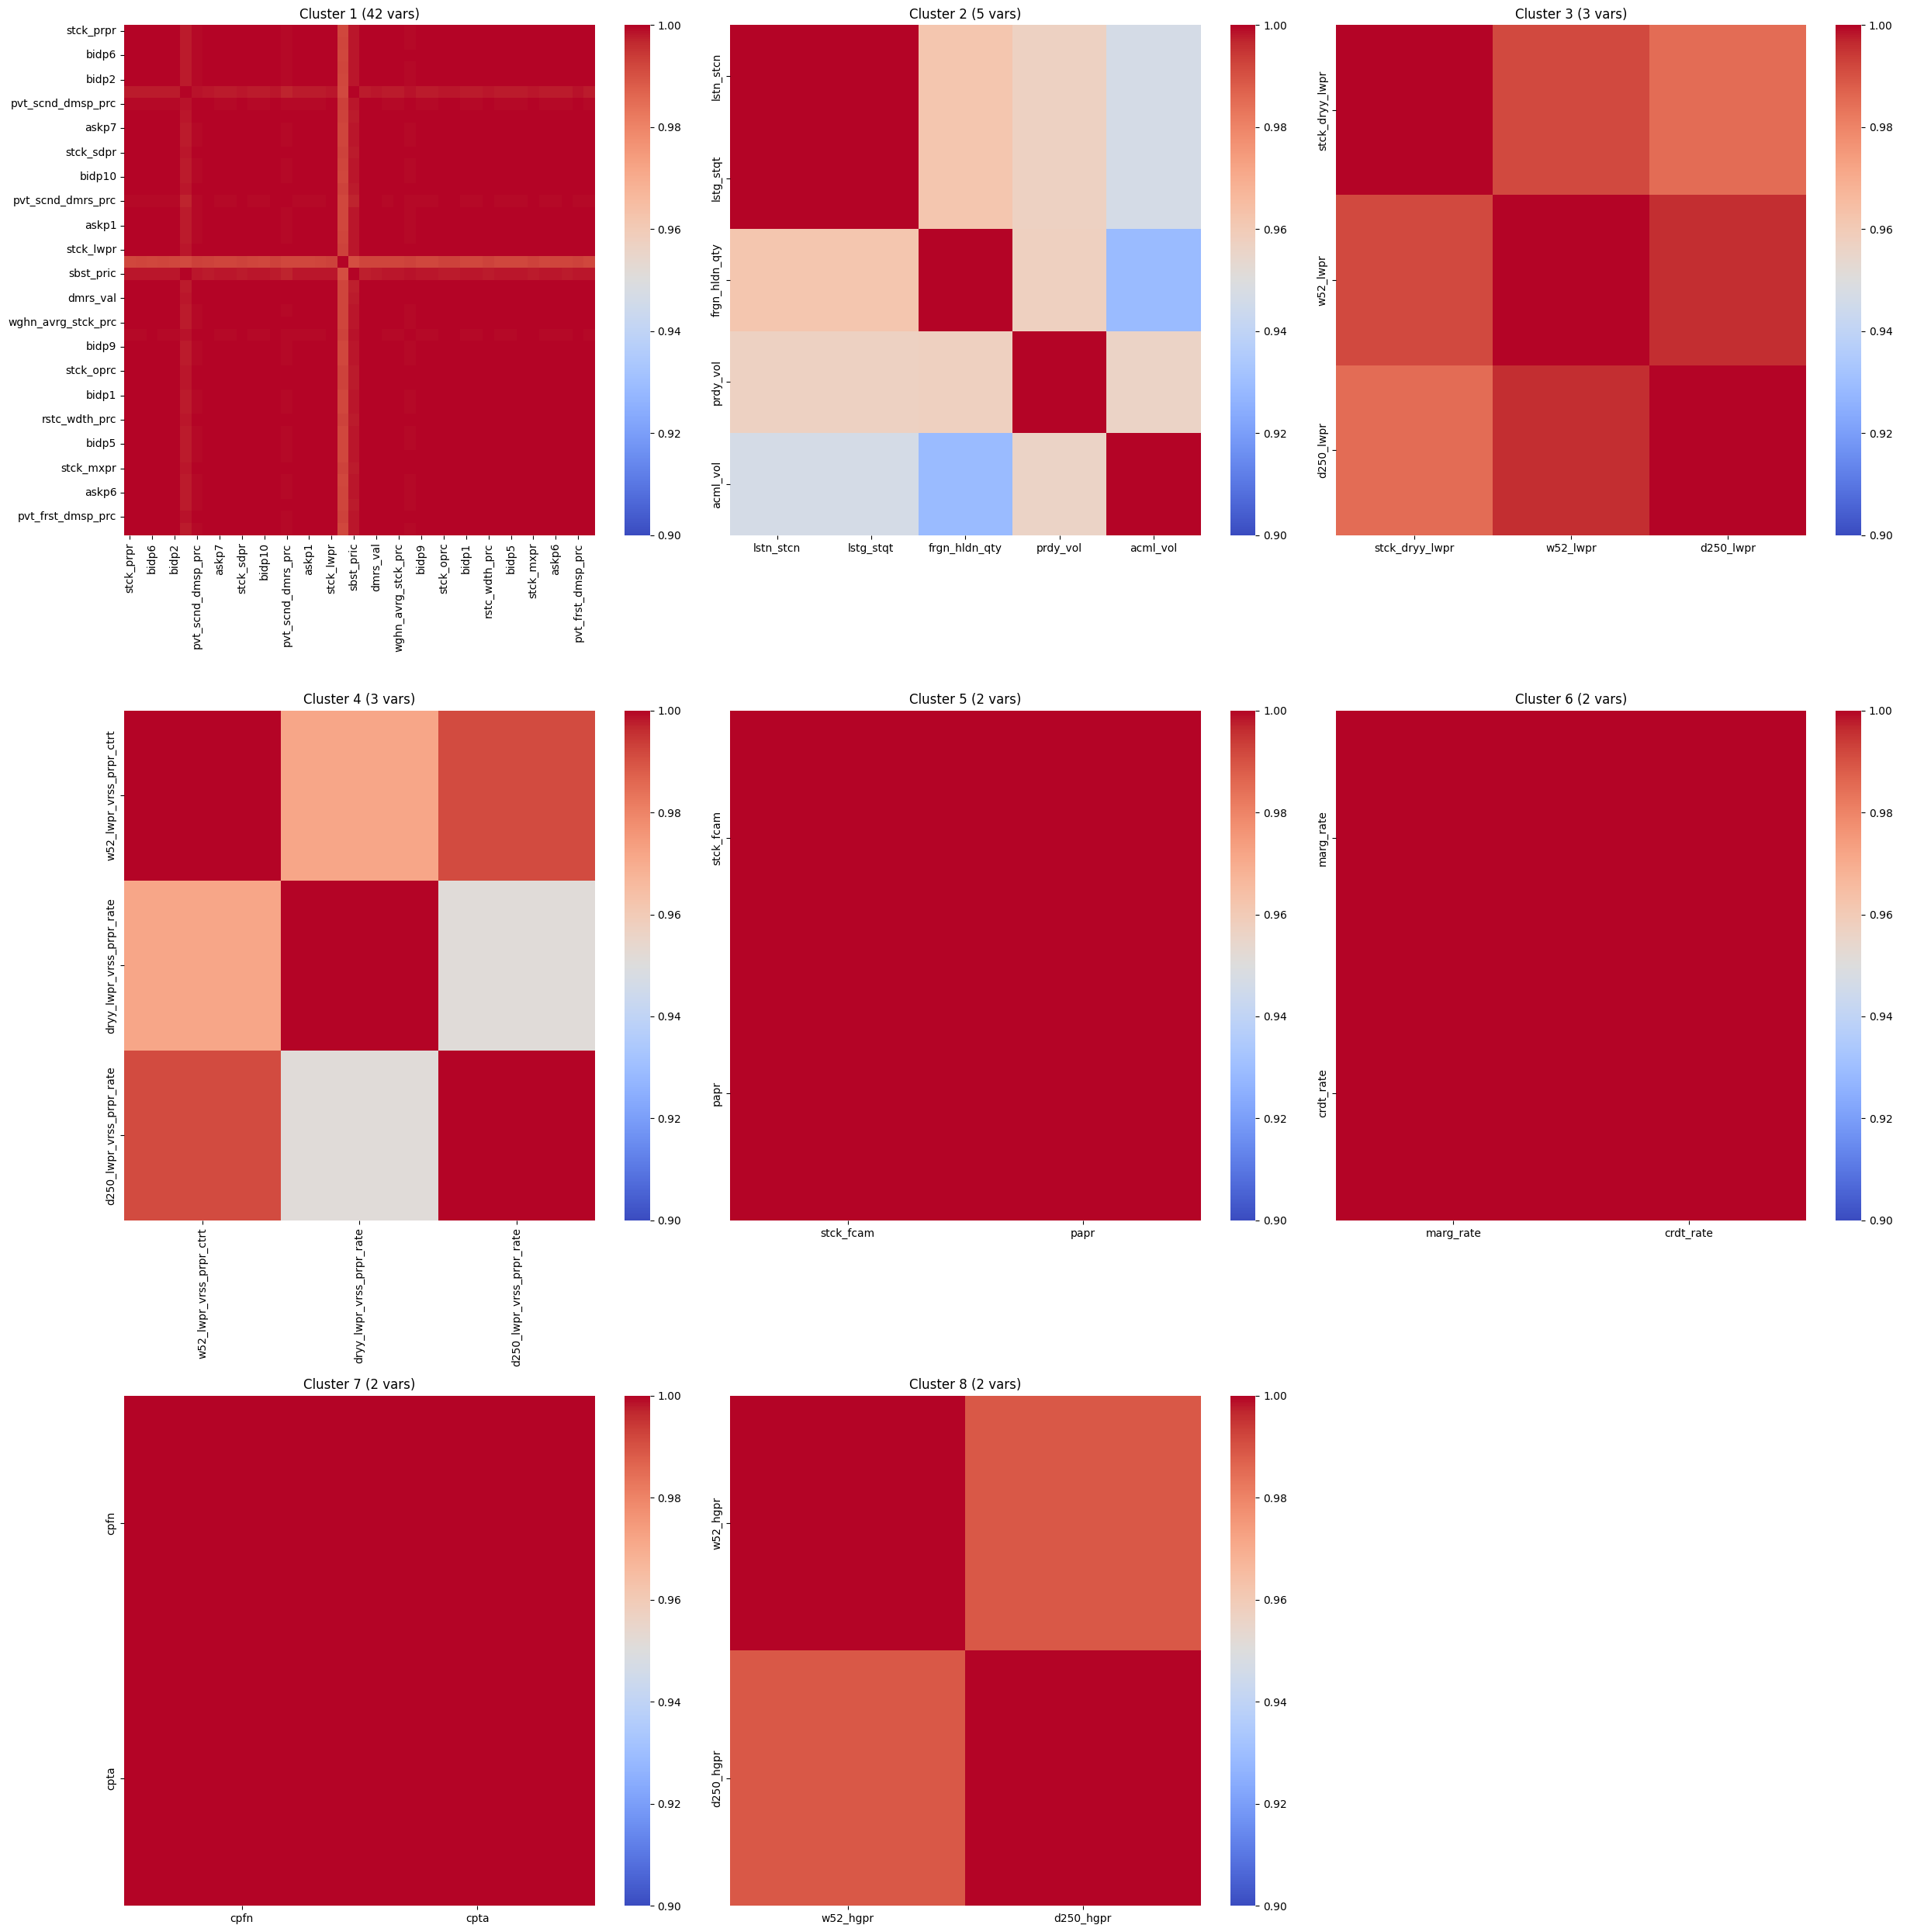

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# --- Í∏∞Ï°¥ Í∑∏Î£πÌïë ÏΩîÎìú ---
G = nx.Graph()
edges = [(pair[0], pair[1]) for pair in num_high_corr_pairs]
G.add_edges_from(edges)
clusters = list(nx.connected_components(G))

print(f"‚úÖ Ï¥ù {len(clusters)}Í∞úÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∑∏Î£πÏùÑ ÏûêÎèôÏúºÎ°ú Ï∞æÏïòÏäµÎãàÎã§.")
print("-" * 50)

# 1. 3x3 Í∑∏Î¶¨Îìú(subplot)Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§. Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î•º ÌÅ¨Í≤å ÏÑ§Ï†ïÌï©ÎãàÎã§.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))

# 2. axes Î∞∞Ïó¥ÏùÑ 1Ï∞®ÏõêÏúºÎ°ú ÌéºÏ≥êÏÑú Îã§Î£®Í∏∞ ÏâΩÍ≤å ÎßåÎì≠ÎãàÎã§.
ax_flat = axes.flatten()

# 3. ÌÅ¥Îü¨Ïä§ÌÑ∞Î•º ÌÅ¨Í∏∞ ÏàúÏúºÎ°ú Ï†ïÎ†¨Ìï©ÎãàÎã§.
sorted_clusters = sorted(clusters, key=len, reverse=True)

# 4. Í∞Å ÌÅ¥Îü¨Ïä§ÌÑ∞Ïóê ÎåÄÌï¥ Î£®ÌîÑÎ•º Ïã§ÌñâÌïòÎ©∞ ÏàúÏÑúÎåÄÎ°ú subplotÏóê ÌûàÌä∏ÎßµÏùÑ Í∑∏Î¶ΩÎãàÎã§.
for i, cluster_vars in enumerate(sorted_clusters):
  ax = ax_flat[i] # ÌòÑÏû¨ Í∑∏Î¶¥ subplot ÏúÑÏπò ÏÑ†ÌÉù
  
  if len(cluster_vars) > 1:
    cluster_df = numeric_df[list(cluster_vars)]
    cluster_corr_matrix = cluster_df.corr()
    
    # cmap='coolwarm'ÏúºÎ°ú ÏÉâÏÉÅ Î≥ÄÍ≤Ω, ax=axÎ°ú ÏúÑÏπò ÏßÄÏ†ï
    sns.heatmap(cluster_corr_matrix, cmap='coolwarm', ax=ax, vmin=0.9, vmax=1.0)
    ax.set_title(f'Cluster {i+1} ({len(cluster_vars)} vars)')
  else:
    # Î≥ÄÏàòÍ∞Ä ÌïòÎÇòÎøêÏù∏ ÌÅ¥Îü¨Ïä§ÌÑ∞Îäî ÎπÑÏõåÎë°ÎãàÎã§.
    ax.axis('off')

# 5. ÎßåÏïΩ ÌÅ¥Îü¨Ïä§ÌÑ∞ Í∞úÏàòÍ∞Ä 12Í∞úÎ≥¥Îã§ Ï†ÅÏùÑ Í≤ΩÏö∞, ÎÇ®Îäî subplot Í≥µÍ∞ÑÏùÑ Ïà®ÍπÅÎãàÎã§.
for i in range(len(sorted_clusters), len(ax_flat)):
  ax_flat[i].axis('off')

# 6. Í∑∏ÎûòÌîÑÎì§Ïù¥ Í≤πÏπòÏßÄ ÏïäÎèÑÎ°ù Î†àÏù¥ÏïÑÏõÉÏùÑ ÏûêÎèô Ï°∞Ï†ïÌï©ÎãàÎã§.
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

print("\n\n" + "="*80)
print("Í∞Å Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏÉÅÍ¥ÄÍ≥ÑÏàò Î∂ÑÏÑù (ÎåÄÌëú Î≥ÄÏàò ÏÑ†Ï†ïÏùÑ ÏúÑÌïú ÏµúÏ¢Ö Î∂ÑÏÑù)")
print("="*80)

# --- Í∞Å Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏÉÅÍ¥ÄÍ≥ÑÏàò Í≥ÑÏÇ∞ Î∞è Ï∂úÎ†• Î°úÏßÅ ---
for i, cluster_vars in enumerate(sorted_clusters):
  cluster_num = i + 1
  
  if len(cluster_vars) > 1:
    # 1. Ï†ÑÏ≤¥ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌñâÎ†¨ÏóêÏÑú ÌòÑÏû¨ ÌÅ¥Îü¨Ïä§ÌÑ∞Ïóê Ìï¥ÎãπÌïòÎäî Î∂ÄÎ∂ÑÎßå ÏÑ†ÌÉù
    cluster_corr = corr_matrix.loc[list(cluster_vars), list(cluster_vars)]
    
    # 2. Í∞Å Î≥ÄÏàòÎ≥ÑÎ°ú Îã§Î•∏ Î≥ÄÏàòÎì§Í≥ºÏùò ÌèâÍ∑† ÏÉÅÍ¥ÄÍ≥ÑÏàò(Ï†àÎåìÍ∞í Í∏∞Ï§Ä)Î•º Í≥ÑÏÇ∞
    #    .abs()Î•º ÌÜµÌï¥ Ïñë/ÏùåÏùò Î∞©Ìñ•ÏÑ± ÏóÜÏù¥ Í¥ÄÍ≥ÑÏùò Í∞ïÎèÑÎßåÏúºÎ°ú Í≥ÑÏÇ∞
    avg_corr = cluster_corr.abs().mean().sort_values(ascending=False)
    
    # 3. Í≤∞Í≥º Ï∂úÎ†•
    header_text = f" Cluster {cluster_num} ({len(cluster_vars)} vars) Average Correlation "
    print(f"\n{header_text.center(80, '-')}")
    print(avg_corr)



Í∞Å Í∑∏Î£πÎ≥Ñ ÌèâÍ∑† ÏÉÅÍ¥ÄÍ≥ÑÏàò Î∂ÑÏÑù (ÎåÄÌëú Î≥ÄÏàò ÏÑ†Ï†ïÏùÑ ÏúÑÌïú ÏµúÏ¢Ö Î∂ÑÏÑù)

------------------- Cluster 1 (42 vars) Average Correlation --------------------
wghn_avrg_stck_prc    0.999628
stck_lwpr             0.999627
bidp4                 0.999621
bidp5                 0.999621
bidp6                 0.999620
bidp7                 0.999619
bidp3                 0.999617
bidp8                 0.999616
bidp9                 0.999615
bidp2                 0.999611
bidp1                 0.999611
bidp10                0.999610
askp3                 0.999609
askp4                 0.999609
askp5                 0.999608
askp2                 0.999607
askp6                 0.999606
askp7                 0.999605
askp8                 0.999604
askp9                 0.999602
askp1                 0.999597
bfdy_clpr             0.999596
stck_prpr             0.999596
thdt_clpr             0.999596
askp10                0.999596
stck_hgpr             0.999581
stck_llam             

### Í∑∏Î£π 1: Í∞ÄÍ≤©(Price) ÌïµÏã¨ Í∑∏Î£π Î∂ÑÏÑù
| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| **(ÏùºÏùº ÌïµÏã¨ Í∞ÄÍ≤©)** | | | |
| `thdt_clpr` | ÎãπÏùº Ï¢ÖÍ∞Ä | **ÏÑ†Ï†ï** | ÌïòÎ£®Ïùò Í∞ÄÍ≤©ÏùÑ ÎåÄÌëúÌïòÎäî Í∞ÄÏû• ÌëúÏ§ÄÏ†ÅÏù∏ ÏßÄÌëú. |
| `bfdy_clpr` | Ï†ÑÏùº Ï¢ÖÍ∞Ä | **ÏÑ†Ï†ï** | ÎãπÏùº Îì±ÎùΩÎ•† Í≥ÑÏÇ∞Ïùò Í∏∞Ï§ÄÏù¥ ÎêòÎäî ÌïµÏã¨ Ï†ïÎ≥¥. |
| `stck_oprc` | ÎãπÏùº ÏãúÍ∞Ä | **ÏÑ†Ï†ï** | Ïû• ÏãúÏûë Í∞ÄÍ≤©ÏúºÎ°ú, ÌïòÎ£®Ïùò Ï∂îÏÑ∏Î•º Î∂ÑÏÑùÌïòÎäî Îç∞ ÌïÑÏàòÏ†Å. |
| `stck_hgpr` | ÎãπÏùº Í≥†Í∞Ä | **ÏÑ†Ï†ï** | ÎãπÏùº Î≥ÄÎèôÏÑ±Ïùò ÏÉÅÎã®ÏùÑ ÎÇòÌÉÄÎÇ¥Îäî ÌïµÏã¨ Ï†ïÎ≥¥. |
| `stck_lwpr` | ÎãπÏùº Ï†ÄÍ∞Ä | **ÏÑ†Ï†ï** | ÎãπÏùº Î≥ÄÎèôÏÑ±Ïùò ÌïòÎã®ÏùÑ ÎÇòÌÉÄÎÇ¥Îäî ÌïµÏã¨ Ï†ïÎ≥¥. |
| `wghn_avrg_stck_prc`| Í∞ÄÏ§ëÌèâÍ∑†Ï£ºÍ∞Ä(VWAP) | **ÏÑ†Ï†ï** | Í±∞ÎûòÎüâÏùÑ Î∞òÏòÅÌïú Ïã§ÏßàÏ†ÅÏù∏ ÌèâÍ∑† Ï≤¥Í≤∞Í∞ÄÎ°ú, Í≥†Ïú†Ìïú Ï†ïÎ≥¥Î•º Ï†úÍ≥µ. |
| `stck_prpr` | ÌòÑÏû¨Í∞Ä | Ï†úÍ±∞ | `thdt_clpr`(Ï¢ÖÍ∞Ä)ÏôÄ Ï†ïÎ≥¥Í∞Ä ÏôÑÏ†ÑÌûà ÎèôÏùº. (ÎåÄÏ≤¥ Í∞ÄÎä•: `thdt_clpr`) |
| **(Í∞ÄÍ≤© Ï†úÌïúÌè≠/Í∏∞Ï§ÄÍ∞Ä)** | | | |
| `stck_mxpr` | ÎãπÏùº ÏÉÅÌïúÍ∞Ä | **ÏÑ†Ï†ï** | Í∞ÄÍ≤© Î≥ÄÎèôÏùò ÏÉÅÎã® Í≤ΩÍ≥Ñ. |
| `stck_llam` | ÎãπÏùº ÌïòÌïúÍ∞Ä | **ÏÑ†Ï†ï** | Í∞ÄÍ≤© Î≥ÄÎèôÏùò ÌïòÎã® Í≤ΩÍ≥Ñ. |
| `stck_sdpr` | ÎãπÏùº Í∏∞Ï§ÄÍ∞Ä | **ÏÑ†Ï†ï** | Í∞ÄÍ≤©Ï†úÌïúÌè≠ Í≥ÑÏÇ∞Ïùò Í∏∞Ï§ÄÏù¥ ÎêòÎäî Í∞ÄÍ≤©. |
| `stck_sspr` | ÎåÄÏö©Í∞Ä | **ÏÑ†Ï†ï** | Ï¶ùÍ±∞Í∏àÏúºÎ°ú ÏÇ¨Ïö©Îê† ÎïåÏùò Í∞ÄÍ≤©ÏúºÎ°ú, ÏãúÏû• Ï†úÎèÑÏôÄ Í¥ÄÎ†®Îêú Í≥†Ïú† Ï†ïÎ≥¥. |
| `sbst_pric` | Í∏∞Ï§ÄÍ∞Ä | **ÏÑ†Ï†ï** | Ï£ºÏãùÏùò Í∞ÄÏπòÎ•º ÌèâÍ∞ÄÌïòÎäî Îòê Îã§Î•∏ Í∏∞Ï§Ä Í∞ÄÍ≤©ÏúºÎ°ú Í≥†Ïú† Ï†ïÎ≥¥Î•º Í∞ÄÏßà Ïàò ÏûàÏùå. |
| `rstc_wdth_prc` | Í∞ÄÍ≤©Ï†úÌïúÌè≠ | Ï†úÍ±∞ | `stck_mxpr`(ÏÉÅÌïúÍ∞Ä)ÏôÄ `stck_llam`(ÌïòÌïúÍ∞Ä)Î°ú Í≥ÑÏÇ∞ Í∞ÄÎä•Ìïú Ï†ïÎ≥¥. |
| `stck_prdy_clpr` | Ï†ÑÏùº Ï¢ÖÍ∞Ä | Ï†úÍ±∞ | `bfdy_clpr`ÏôÄ Ï†ïÎ≥¥Í∞Ä ÏôÑÏ†ÑÌûà ÎèôÏùº. (ÎåÄÏ≤¥ Í∞ÄÎä•: `bfdy_clpr`) |
| **(Îß§ÎèÑ Ìò∏Í∞Ä)** | | | |
| `askp1` | ÏµúÏö∞ÏÑ† Îß§ÎèÑÌò∏Í∞Ä | **ÏÑ†Ï†ï** | Îß§ÎèÑ-Îß§Ïàò Ïä§ÌîÑÎ†àÎìúÎ•º ÌååÏïÖÌïòÍ≥† Ïã§ÏßàÏ†ÅÏù∏ Îß§ÎèÑ ÏïïÎ†•ÏùÑ Î∂ÑÏÑùÌïòÎäî ÌïµÏã¨ ÏßÄÌëú. |
| `askp10` | 10ÏàúÏúÑ Îß§ÎèÑÌò∏Í∞Ä | **ÏÑ†Ï†ï** | Ìò∏Í∞ÄÏ∞ΩÏùò ÍπäÏù¥Î•º ÎåÄÎûµÏ†ÅÏúºÎ°ú ÌååÏïÖÌï† Ïàò ÏûàÎäî ÏßÄÌëú. |
| `askp2` ~ `askp9` | 2~9ÏàúÏúÑ Îß§ÎèÑÌò∏Í∞Ä | Ï†úÍ±∞ | `askp1` Î∞è `askp10`Í≥º ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í∑πÎèÑÎ°ú ÎÜíÏúºÎ©∞, `askp1`Í≥º `askp10`ÏúºÎ°ú ÌïµÏã¨ Ï†ïÎ≥¥Î•º ÎåÄÌëúÌï† Ïàò ÏûàÏùå. |
| **(Îß§Ïàò Ìò∏Í∞Ä)** | | | |
| `bidp1` | ÏµúÏö∞ÏÑ† Îß§ÏàòÌò∏Í∞Ä | **ÏÑ†Ï†ï** | Îß§ÎèÑ-Îß§Ïàò Ïä§ÌîÑÎ†àÎìúÎ•º ÌååÏïÖÌïòÍ≥† Ïã§ÏßàÏ†ÅÏù∏ Îß§Ïàò ÏïïÎ†•ÏùÑ Î∂ÑÏÑùÌïòÎäî ÌïµÏã¨ ÏßÄÌëú. |
| `bidp10` | 10ÏàúÏúÑ Îß§ÏàòÌò∏Í∞Ä | **ÏÑ†Ï†ï** | Ìò∏Í∞ÄÏ∞ΩÏùò ÍπäÏù¥Î•º ÎåÄÎûµÏ†ÅÏúºÎ°ú ÌååÏïÖÌï† Ïàò ÏûàÎäî ÏßÄÌëú. |
| `bidp2` ~ `bidp9` | 2~9ÏàúÏúÑ Îß§ÏàòÌò∏Í∞Ä | Ï†úÍ±∞ | `bidp1` Î∞è `bidp10`Í≥º ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä Í∑πÎèÑÎ°ú ÎÜíÏúºÎ©∞, `bidp1`Í≥º `bidp10`ÏúºÎ°ú ÌïµÏã¨ Ï†ïÎ≥¥Î•º ÎåÄÌëúÌï† Ïàò ÏûàÏùå. |
| **(Í∏∞Ïà†Ï†Å ÏßÄÌëú)** | | | |
| `pvt_pont_val` | ÌîºÎ¥á Í∏∞Ï§ÄÏÑ† | **ÏÑ†Ï†ï** | ÌîºÎ¥á Î∂ÑÏÑùÏùò Ï§ëÏã¨Ïù¥ ÎêòÎäî Í∏∞Ï§ÄÏÑ†. |
| `pvt_frst_dmrs_prc` | ÌîºÎ¥á 1Ï∞® Ï†ÄÌï≠ÏÑ† | **ÏÑ†Ï†ï** | ÌîºÎ¥á Í∏∞Î∞òÏùò Ï£ºÏöî Ï†ÄÌï≠ Î†àÎ≤®. |
| `pvt_scnd_dmrs_prc` | ÌîºÎ¥á 2Ï∞® Ï†ÄÌï≠ÏÑ† | **ÏÑ†Ï†ï** | ÌîºÎ¥á Í∏∞Î∞òÏùò Ï£ºÏöî Ï†ÄÌï≠ Î†àÎ≤®. |
| `pvt_frst_dmsp_prc` | ÌîºÎ¥á 1Ï∞® ÏßÄÏßÄÏÑ† | **ÏÑ†Ï†ï** | ÌîºÎ¥á Í∏∞Î∞òÏùò Ï£ºÏöî ÏßÄÏßÄ Î†àÎ≤®. |
| `pvt_scnd_dmsp_prc` | ÌîºÎ¥á 2Ï∞® ÏßÄÏßÄÏÑ† | **ÏÑ†Ï†ï** | ÌîºÎ¥á Í∏∞Î∞òÏùò Ï£ºÏöî ÏßÄÏßÄ Î†àÎ≤®. |
| `dmrs_val` | ÎîîÎßàÌÅ¨ Í≥†Í∞Ä(Ï†ÄÌï≠) | **ÏÑ†Ï†ï** | ÌîºÎ¥áÍ≥ºÎäî Îã§Î•∏ Î∞©ÏãùÏúºÎ°ú Í≥ÑÏÇ∞Îêú Í∏∞Ïà†Ï†Å Ï†ÄÌï≠ÏÑ†. |
| `dmsp_val` | ÎîîÎßàÌÅ¨ Ï†ÄÍ∞Ä(ÏßÄÏßÄ) | **ÏÑ†Ï†ï** | ÌîºÎ¥áÍ≥ºÎäî Îã§Î•∏ Î∞©ÏãùÏúºÎ°ú Í≥ÑÏÇ∞Îêú Í∏∞Ïà†Ï†Å ÏßÄÏßÄÏÑ†. |
| **(Ïó≠ÏÇ¨Ï†Å Í≥†Ï†ê)** | | | |
| `stck_dryy_hgpr` | Ïó∞Ï§ë ÏµúÍ≥†Í∞Ä | **ÏÑ†Ï†ï** | Ïó∞Ï¥à ÎåÄÎπÑ Î™®Î©òÌÖÄÏùÑ Î∂ÑÏÑùÌïòÍ∏∞ ÏúÑÌïú Í≥†Ïú†Ìïú Í∏∞Í∞ÑÏùò ÏµúÍ≥†Í∞Ä Ï†ïÎ≥¥. |

---
### Í∑∏Î£π 2: ÏàòÎüâ(Quantity) Í∑∏Î£π Î∂ÑÏÑù
| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| `lstg_stqt` | ÏÉÅÏû•Ï£ºÏãùÏàò | **ÏÑ†Ï†ï** | Í∏∞ÏóÖÏùò Í∑úÎ™®ÏôÄ Ïú†ÌÜµ Ï£ºÏãù ÏàòÎ•º ÎÇòÌÉÄÎÇ¥Îäî ÌïµÏã¨ ÌéÄÎçîÎ©òÌÑ∏ ÏßÄÌëú. |
| `lstn_stcn` | ÏÉÅÏû•Ï£ºÏãùÏàò (Ï§ëÎ≥µ) | Ï†úÍ±∞ | `lstg_stqt`ÏôÄ Ï†ïÎ≥¥Í∞Ä ÏôÑÏ†ÑÌûà ÎèôÏùºÌï®. (ÎåÄÏ≤¥ Í∞ÄÎä•: `lstg_stqt`) |
| `acml_vol` | ÎàÑÏ†Å Í±∞ÎûòÎüâ | **ÏÑ†Ï†ï** | ÎãπÏùº ÏãúÏû•Ïùò Í¥ÄÏã¨ÎèÑÏôÄ ÌôúÎèôÏÑ±ÏùÑ ÎÇòÌÉÄÎÇ¥Îäî Í∞ÄÏû• Ï§ëÏöîÌïú ÏßÄÌëú. |
| `prdy_vol` | Ï†ÑÏùº Í±∞ÎûòÎüâ | **ÏÑ†Ï†ï** | ÎãπÏùº Í±∞ÎûòÎüâÍ≥ºÏùò ÎπÑÍµêÎ•º ÌÜµÌï¥ Í±∞ÎûòÎüâÏùò Í∏âÏ¶ù/Í∏âÍ∞êÏùÑ ÌååÏïÖÌïòÎäî Îç∞ ÌïÑÏöîÌïú Í≥†Ïú† Ï†ïÎ≥¥. |
| `frgn_hldn_qty`| Ïô∏Íµ≠Ïù∏ Î≥¥Ïú†ÏàòÎüâ | **ÏÑ†Ï†ï** | ÏàòÍ∏â Ï£ºÏ≤¥Î•º ÌååÏïÖÌïòÎäî ÌïµÏã¨ ÏßÄÌëúÎ°ú, Îã§Î•∏ ÏàòÎüâ ÏßÄÌëúÏôÄÎäî Îã§Î•∏ Í≥†Ïú†Ìïú Ï†ïÎ≥¥Î•º Ï†úÍ≥µ. |

---
### Í∑∏Î£π 3: Ïó≠ÏÇ¨Ï†Å Ï†ÄÏ†ê(Historical Lows) Í∑∏Î£π Î∂ÑÏÑù
| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| `w52_lwpr` | 52Ï£º ÏµúÏ†ÄÍ∞Ä | **ÏÑ†Ï†ï** | ÏïΩ 1ÎÖÑÍ∞ÑÏùò Ïû•Í∏∞Ï†ÅÏù∏ Í¥ÄÏ†êÏóêÏÑú Ï£ºÍ∞ÄÏùò ÌïòÎã® ÏßÄÏßÄ Î†àÎ≤®ÏùÑ Î∂ÑÏÑùÌïòÎäî ÌïµÏã¨ ÏßÄÌëú. |
| `d250_lwpr` | 250Ïùº ÏµúÏ†ÄÍ∞Ä | **ÏÑ†Ï†ï** | Í±∞ÎûòÏùº Í∏∞Ï§Ä(ÏïΩ 1ÎÖÑ)Ïùò ÏµúÏ†ÄÍ∞ÄÎ°ú, `w52_lwpr`Í≥º ÎØ∏ÏÑ∏ÌïòÍ≤å Îã§Î•∏ Í∏∞Í∞ÑÏùò Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌïòÏó¨ Î∂ÑÏÑù Í∞ÄÏπòÍ∞Ä ÏûàÏùå. |
| `stck_dryy_lwpr`| Ïó∞Ï§ë ÏµúÏ†ÄÍ∞Ä | **ÏÑ†Ï†ï** | Ìï¥Îãπ Ïó∞ÎèÑ(Year-to-Date) Í∏∞Ï§ÄÏùò ÏµúÏ†ÄÍ∞ÄÎ°ú, Í∏∞Í∞Ñ ÏÑ§Ï†ïÏù¥ Îã§Î•∏ Í≥†Ïú†Ìïú Î™®Î©òÌÖÄ Ï†ïÎ≥¥. |

---
### Í∑∏Î£π 4: Ïó≠ÏÇ¨Ï†Å Ï†ÄÏ†ê ÎåÄÎπÑ Îì±ÎùΩÎ•† Í∑∏Î£π Î∂ÑÏÑù
| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| `w52_lwpr_vrss_prpr_ctrt` | 52Ï£º ÏµúÏ†ÄÍ∞Ä ÎåÄÎπÑ Îì±ÎùΩÎ•† | **ÏÑ†Ï†ï** | Ïû•Í∏∞ Ï†ÄÏ†êÏúºÎ°úÎ∂ÄÌÑ∞Ïùò ÌöåÎ≥µÎ•†ÏùÑ ÎÇòÌÉÄÎÇ¥Îäî ÌëúÏ§ÄÏ†ÅÏù∏ Î™®Î©òÌÖÄ ÏßÄÌëú. |
| `d250_lwpr_vrss_prpr_rate`| 250Ïùº ÏµúÏ†ÄÍ∞Ä ÎåÄÎπÑ Îì±ÎùΩÎ•† | **ÏÑ†Ï†ï** | Í±∞ÎûòÏùº Í∏∞Ï§Ä Ï†ÄÏ†êÏóêÏÑúÏùò ÌöåÎ≥µÎ•†Î°ú, `w52_lwpr` Í∏∞Î∞ò ÏßÄÌëúÏôÄ ÎπÑÍµê Î∂ÑÏÑùÌï† Í∞ÄÏπòÍ∞Ä ÏûàÏùå. |
| `dryy_lwpr_vrss_prpr_rate`| Ïó∞Ï§ë ÏµúÏ†ÄÍ∞Ä ÎåÄÎπÑ Îì±ÎùΩÎ•† | **ÏÑ†Ï†ï** | Ïó∞Ï¥à ÎåÄÎπÑ ÏÑ±Í≥ºÎ•º Ï∏°Ï†ïÌïòÎäî Í≥†Ïú†Ìïú Í¥ÄÏ†êÏùò ÏßÄÌëú. |

---
### Í∑∏Î£π 5: Ïï°Î©¥Í∞Ä(Par Value) Í∑∏Î£π Î∂ÑÏÑù
| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| `papr` | Ïï°Î©¥Í∞Ä | **ÏÑ†Ï†ï** | Ï£ºÏãùÏùò Ïï°Î©¥ Í∞ÄÍ≤© Ï†ïÎ≥¥. |
| `stck_fcam` | Ïï°Î©¥Í∞Ä (Ï§ëÎ≥µ) | Ï†úÍ±∞ | `papr`Í≥º Ï†ïÎ≥¥Í∞Ä ÏôÑÏ†ÑÌûà ÎèôÏùºÌï®. (ÎåÄÏ≤¥ Í∞ÄÎä•: `papr`) |

---
### Í∑∏Î£π 6: Ï¶ùÍ±∞Í∏àÎ•†(Margin Rate) Í∑∏Î£π Î∂ÑÏÑù
| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| `marg_rate` | Ï¶ùÍ±∞Í∏àÎ•† | **ÏÑ†Ï†ï** | Ïã†Ïö©Í±∞Îûò Í∞ÄÎä• Ïó¨Î∂ÄÏôÄ Î†àÎ≤ÑÎ¶¨ÏßÄ ÏàòÏ§ÄÏùÑ ÎÇòÌÉÄÎÇ¥Îäî ÏãúÏû• Ï†úÎèÑ Í¥ÄÎ†® ÏßÄÌëú. |
| `crdt_rate` | Ïã†Ïö©ÎπÑÏú® | Ï†úÍ±∞ | `marg_rate`ÏôÄ ÎèôÏùºÌïú Ï†ïÎ≥¥Î•º ÎÇòÌÉÄÎÉÑ. (ÎåÄÏ≤¥ Í∞ÄÎä•: `marg_rate`) |

---
### Í∑∏Î£π 7: ÏûêÎ≥∏Í∏à(Capital) Í∑∏Î£π Î∂ÑÏÑù
| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| `cpta` | ÏûêÎ≥∏Í∏à | **ÏÑ†Ï†ï** | Í∏∞ÏóÖÏùò ÏûêÎ≥∏ Í∑úÎ™®Î•º ÎÇòÌÉÄÎÇ¥Îäî ÌéÄÎçîÎ©òÌÑ∏ ÏßÄÌëú. |
| `cpfn` | ÏûêÎ≥∏Í∏à (Ï§ëÎ≥µ) | Ï†úÍ±∞ | `cpta`ÏôÄ Ï†ïÎ≥¥Í∞Ä ÏôÑÏ†ÑÌûà ÎèôÏùºÌï®. (ÎåÄÏ≤¥ Í∞ÄÎä•: `cpta`) |

---
### Í∑∏Î£π 8: Ïó≠ÏÇ¨Ï†Å Í≥†Ï†ê(Historical Highs) Í∑∏Î£π Î∂ÑÏÑù
| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| `w52_hgpr` | 52Ï£º ÏµúÍ≥†Í∞Ä | **ÏÑ†Ï†ï** | Ïû•Í∏∞(1ÎÖÑ) Í¥ÄÏ†êÏùò Ï†ÄÌï≠ Î†àÎ≤® Î∞è Î™®Î©òÌÖÄÏùÑ Î∂ÑÏÑùÌïòÎäî ÌïµÏã¨ ÏßÄÌëú. |
| `d250_hgpr` | 250Ïùº ÏµúÍ≥†Í∞Ä | **ÏÑ†Ï†ï** | Í±∞ÎûòÏùº Í∏∞Ï§Ä(ÏïΩ 1ÎÖÑ)Ïùò ÏµúÍ≥†Í∞ÄÎ°ú, `w52_hgpr`Í≥º ÎØ∏ÏÑ∏ÌïòÍ≤å Îã§Î•∏ Í∏∞Í∞ÑÏùò Ï†ïÎ≥¥Î•º Ï†úÍ≥µ. |

In [14]:
# Í∑∏Î£π 1: Í∞ÄÍ≤©(Price) ÌïµÏã¨ Í∑∏Î£π
selected_cluster_1 = [
  'thdt_clpr', 'bfdy_clpr', 'stck_oprc', 'stck_hgpr', 'stck_lwpr', 
  'wghn_avrg_stck_prc', 'stck_mxpr', 'stck_llam', 'stck_sdpr', 
  'stck_sspr', 'sbst_pric', 'askp1', 'askp10', 'bidp1', 'bidp10', 
  'pvt_pont_val', 'pvt_frst_dmrs_prc', 'pvt_scnd_dmrs_prc', 
  'pvt_frst_dmsp_prc', 'pvt_scnd_dmsp_prc', 'dmrs_val', 'dmsp_val', 
  'stck_dryy_hgpr'
]
# Í∑∏Î£π 2: ÏàòÎüâ(Quantity) Í∑∏Î£π
selected_cluster_2 = ['lstg_stqt', 'acml_vol', 'prdy_vol', 'frgn_hldn_qty']
# Í∑∏Î£π 3: Ïó≠ÏÇ¨Ï†Å Ï†ÄÏ†ê(Historical Lows) Í∑∏Î£π
selected_cluster_3 = ['w52_lwpr', 'd250_lwpr', 'stck_dryy_lwpr']
# Í∑∏Î£π 4: Ïó≠ÏÇ¨Ï†Å Ï†ÄÏ†ê ÎåÄÎπÑ Îì±ÎùΩÎ•† Í∑∏Î£π
selected_cluster_4 = ['w52_lwpr_vrss_prpr_ctrt', 'd250_lwpr_vrss_prpr_rate', 'dryy_lwpr_vrss_prpr_rate']
# Í∑∏Î£π 5: Ïï°Î©¥Í∞Ä(Par Value) Í∑∏Î£π
selected_cluster_5 = ['papr']
# Í∑∏Î£π 6: Ï¶ùÍ±∞Í∏àÎ•†(Margin Rate) Í∑∏Î£π
selected_cluster_6 = ['marg_rate']
# Í∑∏Î£π 7: ÏûêÎ≥∏Í∏à(Capital) Í∑∏Î£π
selected_cluster_7 = ['cpta']
# Í∑∏Î£π 8: Ïó≠ÏÇ¨Ï†Å Í≥†Ï†ê(Historical Highs) Í∑∏Î£π
selected_cluster_8 = ['w52_hgpr', 'd250_hgpr']

# Î™®Îì† Î¶¨Ïä§Ìä∏Î•º ÌïòÎÇòÎ°ú ÌÜµÌï©
selected_numeric_cols = (
  low_corr_cols +
  selected_cluster_1 +
  selected_cluster_2 +
  selected_cluster_3 +
  selected_cluster_4 +
  selected_cluster_5 +
  selected_cluster_6 +
  selected_cluster_7 +
  selected_cluster_8
)

# --- ÏµúÏ¢Ö Í≤∞Í≥º ÌôïÏù∏ ---
print(f"‚úÖ Ï¥ù {len(selected_numeric_cols)}Í∞úÏùò ÏàòÏπòÌòï Î≥ÄÏàòÍ∞Ä ÏµúÏ¢Ö ÏÑ†Ï†ïÎêòÏóàÏäµÎãàÎã§.")
print("\n--- ÏµúÏ¢Ö ÏÑ†Ï†ïÎêú ÏàòÏπòÌòï Î≥ÄÏàò Î™©Î°ù ---")
print(selected_numeric_cols)

‚úÖ Ï¥ù 87Í∞úÏùò ÏàòÏπòÌòï Î≥ÄÏàòÍ∞Ä ÏµúÏ¢Ö ÏÑ†Ï†ïÎêòÏóàÏäµÎãàÎã§.

--- ÏµúÏ¢Ö ÏÑ†Ï†ïÎêú ÏàòÏπòÌòï Î≥ÄÏàò Î™©Î°ù ---
['prdy_vrss', 'prdy_ctrt', 'acml_tr_pbmn', 'prdy_vrss_vol_rate', 'hts_frgn_ehrt', 'frgn_ntby_qty', 'pgtr_ntby_qty', 'aspr_unit', 'hts_avls', 'per', 'pbr', 'vol_tnrt', 'eps', 'bps', 'd250_hgpr_vrss_prpr_rate', 'dryy_hgpr_vrss_prpr_rate', 'w52_hgpr_vrss_prpr_ctrt', 'whol_loan_rmnd_rate', 'last_ssts_cntg_qty', 'aspr_acpt_hour', 'askp_rsqn1', 'askp_rsqn2', 'askp_rsqn3', 'askp_rsqn4', 'askp_rsqn5', 'askp_rsqn6', 'askp_rsqn7', 'askp_rsqn8', 'askp_rsqn9', 'askp_rsqn10', 'bidp_rsqn1', 'bidp_rsqn2', 'bidp_rsqn3', 'bidp_rsqn4', 'bidp_rsqn5', 'bidp_rsqn6', 'bidp_rsqn7', 'bidp_rsqn8', 'bidp_rsqn9', 'bidp_rsqn10', 'total_askp_rsqn', 'total_bidp_rsqn', 'ntby_aspr_rsqn', 'prdy_clpr_vrss_oprc_rate', 'lwpr_vrss_prpr', 'prdy_clpr_vrss_lwpr_rate', 'hgpr_vrss_prpr', 'prdy_clpr_vrss_hgpr_rate', 'oprc_vrss_prpr', 'thdt_clpr', 'bfdy_clpr', 'stck_oprc', 'stck_hgpr', 'stck_lwpr', 'wghn_avrg_stck

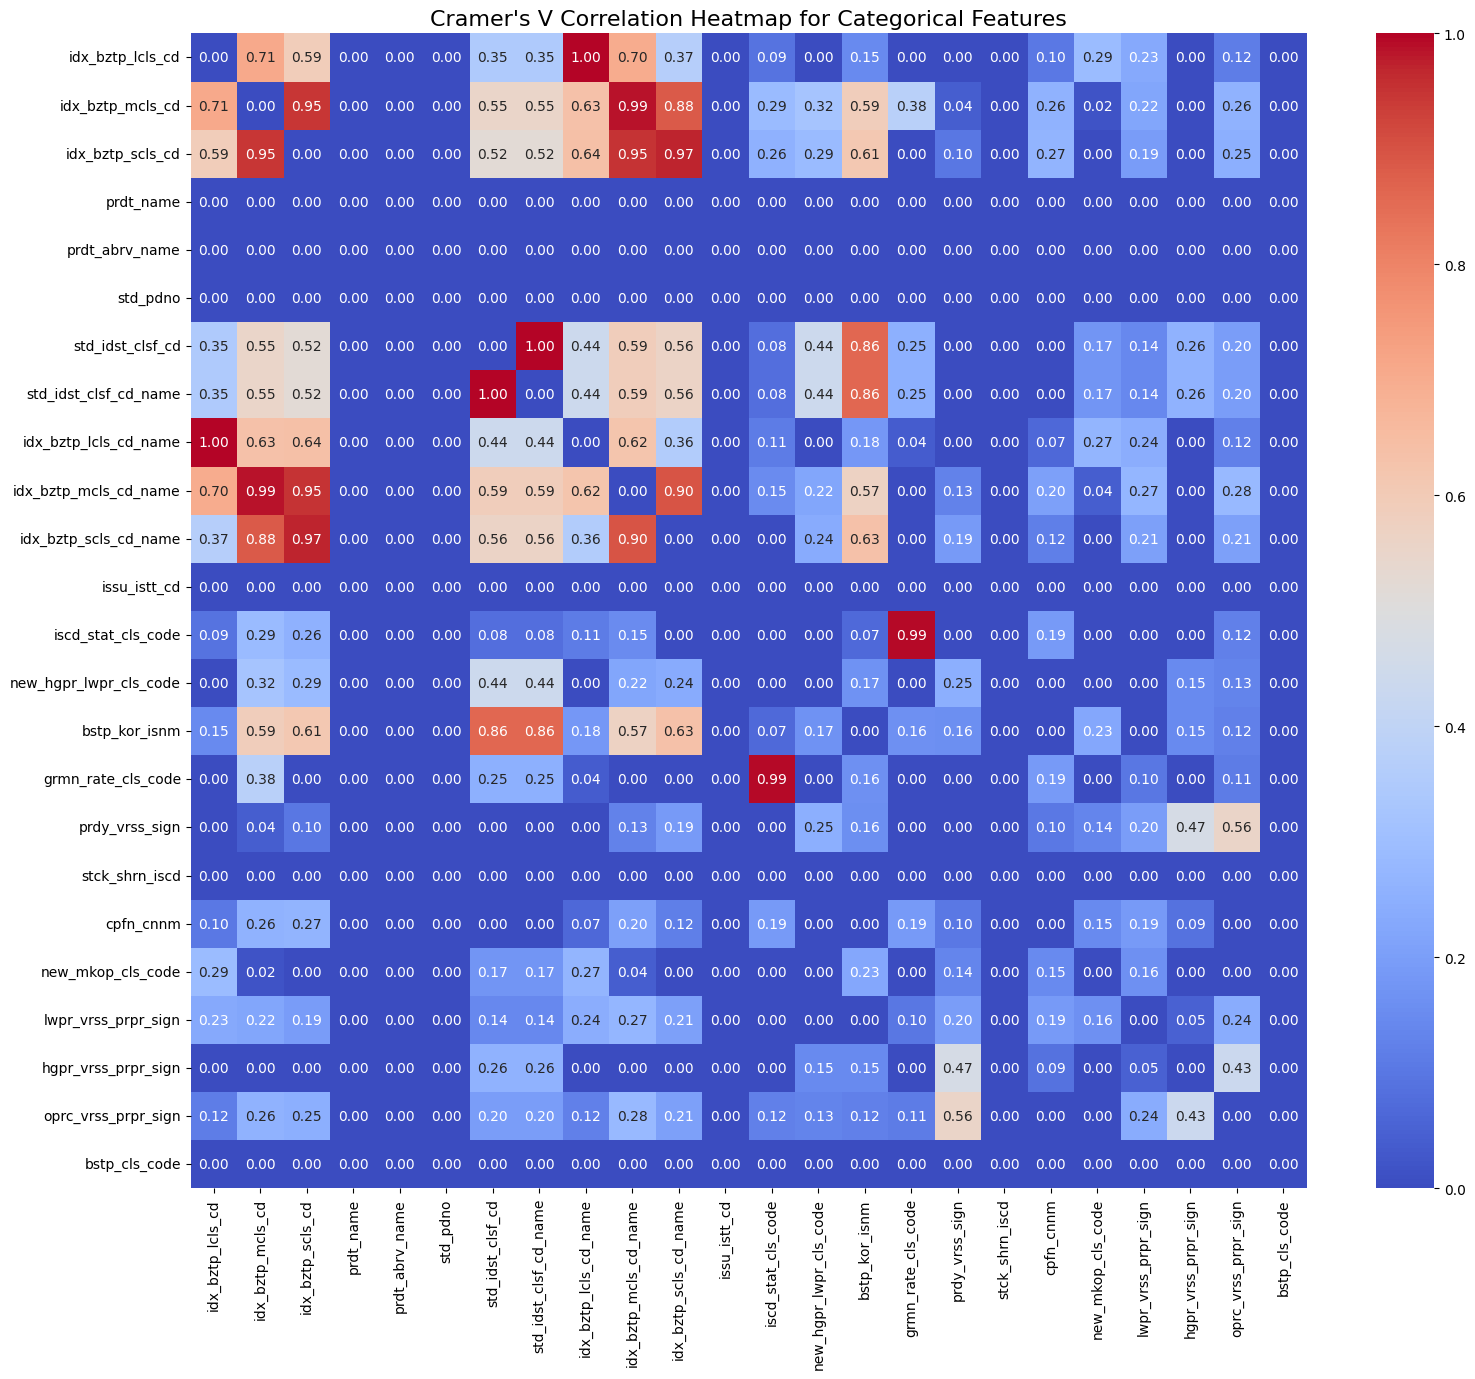


‚úÖ Ï¥ù 6Í∞úÏùò Î≥ÄÏàò ÏåçÏóêÏÑú ÏûÑÍ≥ÑÍ∞í(0.95)ÏùÑ Ï¥àÍ≥ºÌïòÎäî ÎÜíÏùÄ Ïó∞Í¥ÄÏÑ±Ïù¥ Î∞úÍ≤¨ÎêòÏóàÏäµÎãàÎã§.
----------------------------------------------------------------------
Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÜíÏùÄ Î≥ÄÏàò Ïåç:
- std_idst_clsf_cd_name & std_idst_clsf_cd: 1.0000
- idx_bztp_lcls_cd_name & idx_bztp_lcls_cd: 0.9974
- grmn_rate_cls_code & iscd_stat_cls_code: 0.9949
- idx_bztp_mcls_cd_name & idx_bztp_mcls_cd: 0.9859
- idx_bztp_scls_cd_name & idx_bztp_scls_cd: 0.9691
- idx_bztp_mcls_cd_name & idx_bztp_scls_cd: 0.9501

üëâ Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÜíÏùÄ Î≥ÄÏàò Î¶¨Ïä§Ìä∏ (10Í∞ú):
['idx_bztp_scls_cd', 'iscd_stat_cls_code', 'idx_bztp_lcls_cd', 'grmn_rate_cls_code', 'idx_bztp_lcls_cd_name', 'std_idst_clsf_cd', 'idx_bztp_mcls_cd', 'std_idst_clsf_cd_name', 'idx_bztp_mcls_cd_name', 'idx_bztp_scls_cd_name']

üëâ Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÇÆÏùÄ Î≥ÄÏàò Î¶¨Ïä§Ìä∏ (14Í∞ú):
['prdt_name', 'prdt_abrv_name', 'std_pdno', 'issu_istt_cd', 'new_hgpr_lwpr_cls_code', 'bstp_kor_isnm', 'prdy_vrss_sign', 'stck_shrn_iscd', 'cpfn_cnnm', 'n

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import combinations

categorical_df = df_cleaned[cleaned_categorical_cols].astype('str')

# --- Step 1: ÌÅ¨ÎûòÎ®∏ V Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Ìï®Ïàò Ï†ïÏùò ---
def cramers_v(contingency_table):
  """ Îëê Î≤îÏ£ºÌòï Î≥ÄÏàò Í∞ÑÏùò ÌÅ¨ÎûòÎ®∏ V Í≥ÑÏàòÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§. """
  chi2 = chi2_contingency(contingency_table)[0]
  n = contingency_table.sum().sum()
  phi2 = chi2 / n
  r, k = contingency_table.shape
  phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
  r_corr = r - ((r-1)**2)/(n-1)
  k_corr = k - ((k-1)**2)/(n-1)
  if min((k_corr-1), (r_corr-1)) == 0:
    return 0
  else:
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# --- Step 2: ÌÅ¨ÎûòÎ®∏ V ÏÉÅÍ¥Ä ÌñâÎ†¨ Í≥ÑÏÇ∞ ---
cramers_v_matrix = pd.DataFrame(
  np.zeros((len(cleaned_categorical_cols), len(cleaned_categorical_cols))),
  index=cleaned_categorical_cols,
  columns=cleaned_categorical_cols
)

for col1, col2 in combinations(cleaned_categorical_cols, 2):
  contingency = pd.crosstab(categorical_df[col1], categorical_df[col2])
  v = cramers_v(contingency)
  cramers_v_matrix.loc[col1, col2] = v
  cramers_v_matrix.loc[col2, col1] = v

# --- Step 3: ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî ---
plt.figure(figsize=(18, 15))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cramer\'s V Correlation Heatmap for Categorical Features', fontsize=16)
plt.show()

# --- Step 4: Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÜíÏùÄ Î≥ÄÏàò Ïåç Ï∂îÏ∂ú ---
threshold = 0.95
str_high_corr_pairs = []

for i in range(len(cramers_v_matrix.columns)):
  for j in range(i):
    if cramers_v_matrix.iloc[i, j] > threshold:
      pair = (cramers_v_matrix.columns[i], cramers_v_matrix.columns[j], cramers_v_matrix.iloc[i, j])
      str_high_corr_pairs.append(pair)

str_high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\n‚úÖ Ï¥ù {len(str_high_corr_pairs)}Í∞úÏùò Î≥ÄÏàò ÏåçÏóêÏÑú ÏûÑÍ≥ÑÍ∞í({threshold})ÏùÑ Ï¥àÍ≥ºÌïòÎäî ÎÜíÏùÄ Ïó∞Í¥ÄÏÑ±Ïù¥ Î∞úÍ≤¨ÎêòÏóàÏäµÎãàÎã§.")
print("-" * 70)
print("Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÜíÏùÄ Î≥ÄÏàò Ïåç:")
for pair in str_high_corr_pairs:
  print(f"- {pair[0]} & {pair[1]}: {pair[2]:.4f}")

# --- Step 5: Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÜíÏùÄ Î≥ÄÏàòÏôÄ ÎÇÆÏùÄ Î≥ÄÏàò Î¶¨Ïä§Ìä∏ Î∂ÑÎ¶¨ ---

# 1. Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÜíÏùÄ Î≥ÄÏàòÎì§Ïùò Ïù¥Î¶ÑÎßå Ï∂îÏ∂ú (Ï§ëÎ≥µ Ï†úÍ±∞Î•º ÏúÑÌï¥ set ÏÇ¨Ïö©)
high_corr_cols_set = set()
for pair in str_high_corr_pairs:
  high_corr_cols_set.add(pair[0])
  high_corr_cols_set.add(pair[1])

high_corr_cols = list(high_corr_cols_set)

# 2. Ï†ÑÏ≤¥ Î≤îÏ£ºÌòï Î≥ÄÏàò Ï§ë, high_corr_colsÏóê Ìè¨Ìï®ÎêòÏßÄ ÏïäÏùÄ Î≥ÄÏàòÎì§Îßå ÏÑ†ÌÉù
low_corr_cols = [col for col in cleaned_categorical_cols if col not in high_corr_cols]

# 3. Í≤∞Í≥º ÌôïÏù∏
print("\n" + "="*70)
print(f"üëâ Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÜíÏùÄ Î≥ÄÏàò Î¶¨Ïä§Ìä∏ ({len(high_corr_cols)}Í∞ú):")
print(high_corr_cols)
print("\n" + "="*70)
print(f"üëâ Ïó∞Í¥ÄÏÑ±Ïù¥ ÎÇÆÏùÄ Î≥ÄÏàò Î¶¨Ïä§Ìä∏ ({len(low_corr_cols)}Í∞ú):")
print(low_corr_cols)
print("="*70)

### Î≤îÏ£ºÌòï Î≥ÄÏàò Í∑∏Î£π Î∂ÑÏÑù (ÏûÑÍ≥ÑÍ∞í: 0.95)

| Î≥ÄÏàòÎ™Ö | ÌïúÍ∏ÄÎ™Ö | ÏÑ†Ï†ïÏó¨Î∂Ä | ÏÑ†Ï†ï Í∑ºÍ±∞ |
| :--- | :--- | :--- | :--- |
| `std_idst_clsf_cd_name` | ÌëúÏ§ÄÏÇ∞ÏóÖÎ∂ÑÎ•òÎ™Ö | **ÏÑ†Ï†ï** | ÏΩîÎìúÎ≥¥Îã§ ÏÇ¨ÎûåÏù¥ Ìï¥ÏÑùÌïòÍ∏∞ Ïö©Ïù¥Ìïú 'Ïù¥Î¶Ñ' Î≥ÄÏàòÏù¥Î©∞, ÏÇ∞ÏóÖÎ∂ÑÎ•ò Ï†ïÎ≥¥Ïùò ÌïµÏã¨. |
| `std_idst_clsf_cd` | ÌëúÏ§ÄÏÇ∞ÏóÖÎ∂ÑÎ•òÏΩîÎìú | Ï†úÍ±∞ | `std_idst_clsf_cd_name`Ïù¥ ÎèôÏùºÌïú Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌïòÎ©∞, Ìï¥ÏÑùÏù¥ Îçî Ïö©Ïù¥Ìï®. |
| `idx_bztp_lcls_cd_name` | ÏóÖÏ¢Ö ÎåÄÎ∂ÑÎ•òÎ™Ö | **ÏÑ†Ï†ï** | Í∞ÄÏû• ÏÉÅÏúÑ Î†àÎ≤®Ïùò ÏóÖÏ¢Ö Ï†ïÎ≥¥Î°ú, Í±∞ÏãúÏ†ÅÏù∏ Í∑∏Î£π Î∂ÑÏÑùÏóê ÌïÑÏöî. |
| `idx_bztp_lcls_cd` | ÏóÖÏ¢Ö ÎåÄÎ∂ÑÎ•òÏΩîÎìú | Ï†úÍ±∞ | `idx_bztp_lcls_cd_name`Ïù¥ ÎèôÏùºÌïú Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌïòÎ©∞, Ìï¥ÏÑùÏù¥ Îçî Ïö©Ïù¥Ìï®. |
| `idx_bztp_scls_cd_name` | ÏóÖÏ¢Ö ÏÜåÎ∂ÑÎ•òÎ™Ö | **ÏÑ†Ï†ï** | Í∞ÄÏû• ÏÑ∏Î∂ÑÌôîÎêú ÏóÖÏ¢Ö Ï†ïÎ≥¥Î°ú, Ï†ïÎ∞ÄÌïú Î∂ÑÏÑùÏóê ÌïÑÏöî. |
| `idx_bztp_scls_cd` | ÏóÖÏ¢Ö ÏÜåÎ∂ÑÎ•òÏΩîÎìú | Ï†úÍ±∞ | `idx_bztp_scls_cd_name`Ïù¥ ÎèôÏùºÌïú Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌïòÎ©∞, Ìï¥ÏÑùÏù¥ Îçî Ïö©Ïù¥Ìï®. |
| `idx_bztp_mcls_cd_name` | ÏóÖÏ¢Ö Ï§ëÎ∂ÑÎ•òÎ™Ö | Ï†úÍ±∞ | `idx_bztp_scls_cd_name`Í≥º Ïó∞Í¥ÄÏÑ±Ïù¥ Îß§Ïö∞ ÎÜíÏúºÎ©∞, ÏÜåÎ∂ÑÎ•òÍ∞Ä Îçî ÏÑ∏Î∂ÑÌôîÎêú Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌï®. |
| `idx_bztp_mcls_cd` | ÏóÖÏ¢Ö Ï§ëÎ∂ÑÎ•òÏΩîÎìú | Ï†úÍ±∞ | `idx_bztp_scls_cd_name`Ïù¥ Îçî ÏÑ∏Î∂ÑÌôîÎêú Ï†ïÎ≥¥Î•º Ï†úÍ≥µÌï®. |
| `iscd_stat_cls_code` | Ï¢ÖÎ™© ÏÉÅÌÉú Íµ¨Î∂Ñ ÏΩîÎìú | **ÏÑ†Ï†ï** | Í¥ÄÎ¶¨Ï¢ÖÎ™© Ïó¨Î∂ÄÎ•º Ìè¨Ìï®ÌïòÎäî Îçî Ìè¨Í¥ÑÏ†ÅÏù¥Í≥† ÏùºÎ∞òÏ†ÅÏù∏ Ï¢ÖÎ™© ÏÉÅÌÉú Ï†ïÎ≥¥. |
| `grmn_rate_cls_code` | Í¥ÄÎ¶¨ Ï¢ÖÎ™© Íµ¨Î∂Ñ ÏΩîÎìú | Ï†úÍ±∞ | `iscd_stat_cls_code`ÏôÄ Ïó∞Í¥ÄÏÑ±Ïù¥ Îß§Ïö∞ ÎÜíÏïÑ Í±∞Ïùò ÎèôÏùºÌïú ÏÉÅÌÉú Ï†ïÎ≥¥Î•º ÎÇòÌÉÄÎÉÑ. |


In [16]:
selected_categorical_cols = low_corr_cols + [
  'std_idst_clsf_cd_name',
  'idx_bztp_lcls_cd_name',
  'idx_bztp_scls_cd_name',
  'iscd_stat_cls_code'
]
print(f"Ï¥ù {len(selected_categorical_cols)}Í∞úÏùò Î≤îÏ£ºÌòï Î≥ÄÏàòÍ∞Ä ÏµúÏ¢Ö ÏÑ†Ï†ïÎêòÏóàÏäµÎãàÎã§.")

Ï¥ù 18Í∞úÏùò Î≤îÏ£ºÌòï Î≥ÄÏàòÍ∞Ä ÏµúÏ¢Ö ÏÑ†Ï†ïÎêòÏóàÏäµÎãàÎã§.


In [17]:
final_cols = selected_numeric_cols + selected_categorical_cols + cleaned_datetime_cols

print(f"final cols({len(final_cols)}) = numerical({len(selected_numeric_cols)}) + categorical({len(selected_categorical_cols)}) + datetime({len(cleaned_datetime_cols)})")

final cols(112) = numerical(87) + categorical(18) + datetime(7)


In [18]:
final_df = df[final_cols]
final_df

prdy_vrss  prdy_ctrt   acml_tr_pbmn  prdy_vrss_vol_rate  hts_frgn_ehrt  \
0       -800.0      -0.99  1672547819584               81.57          51.11   
1          NaN        NaN  1546050743059               96.89          56.08   
2      -5000.0      -1.41    64980756750              106.97           4.09   
3      -5000.0      -0.49    93367438000              177.89          12.86   
4      -1000.0      -0.10   372660454884              173.56          44.77   
..         ...        ...            ...                 ...            ...   
195     -280.0      -1.54     1041390600               82.04           9.00   
196      -90.0      -1.42     3763664435               50.02           7.33   
197     -100.0      -0.17     2245137800              106.79          12.73   
198     -650.0      -1.52     1123247550              114.50          10.75   
199     -300.0      -0.51     1417938050               54.80           7.28   

     frgn_ntby_qty  pgtr_ntby_qty  aspr_unit  hts_avls    per   pbr  vol_tnrt  \
0        -537726.0         938828        100   4717951  16.10  1.38      0.35   
1        -982503.0        -357729        500   2569848  12.99  3.38      0.60   
2         -23961.0         -36176        500    817830 -80.27  3.87      0.08   
3           5913.0           7932       1000    728822  67.28  6.68      0.13   
4           3680.0          -2295       1000    526978  22.13  9.44      0.71   
..             ...            ...        ...       ...    ...   ...       ...   
195       -23285.0         -19046         10      7305   9.41  0.79      0.14   
196       -21464.0         -35866         10      6682  -9.34  2.05      0.56   
197        11032.0           9321        100      6475   8.91  1.13      0.35   
198        -3941.0          -1129         50      8045  -3.19  0.22      0.14   
199         7162.0           6079        100      5210   5.37  0.43      0.27   

         eps     bps  d250_hgpr_vrss_prpr_rate  dryy_hgpr_vrss_prpr_rate  \
0     4950.0   57930                     -1.85                     -1.85   
1    27182.0  104567                     -1.94                     -1.94   
2    -4354.0   90240                    -21.28                    -13.28   
3    15221.0  153212                    -15.30                    -15.30   
4    46183.0  108270                     -2.85                     -2.85   
..       ...     ...                       ...                       ...   
195   1900.0   22488                    -13.25                     -5.92   
196   -667.0    3044                     -9.45                     -9.45   
197   6569.0   51831                    -31.82                    -31.58   
198 -13195.0  188730                    -33.03                    -22.61   
199  10841.0  134902                    -31.45                    -18.03   

     w52_hgpr_vrss_prpr_ctrt  whol_loan_rmnd_rate  last_ssts_cntg_qty  \
0                      -1.85                 0.17              489779   
1                      -1.94                 0.16               84763   
2                     -21.28                 0.11               45469   
3                     -15.30                 0.09                1706   
4                      -2.85                 0.34                5937   
..                       ...                  ...                 ...   
195                   -13.25                 0.49                2898   
196                    -9.45                 1.97                8112   
197                   -31.82                 2.37                6236   
198                   -93.51                 0.16                 277   
199                   -31.45                 1.83                 911   

     aspr_acpt_hour  askp_rsqn1  askp_rsqn2  askp_rsqn3  askp_rsqn4  \
0            160000       13017      169308      419352      114908   
1            160000       24717       92990      113523       93498   
2            160001        3341        1782        1416        2238   
3        

In [19]:
import pandas as pd

# Î≥¥Í≥†ÏÑú Ï†ÑÏ≤¥ ÎÑàÎπÑ ÏÑ§Ï†ï
WIDTH = 80

print("=" * WIDTH)
print("EDA & Feature Selection Final Report".center(WIDTH))
print("=" * WIDTH)

# --- 1. Îç∞Ïù¥ÌÑ∞ ÌÜµÌï© ÏöîÏïΩ ---
print("\n" + "=" * WIDTH)
print("Step 1: Data Integration Summary".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Initial number of tables: {len(dataframes)}")
print(f"[INFO] Merged into a single DataFrame.")
print("-" * WIDTH)
print(f"[ACTION] Deduplicated features based on priority.")
total_dropped_count = 0
for name in priority_order:
  original_cols = len(dataframes[name].columns)
  dedup_cols = len(deduplicated_dataframes[name].columns)
  dropped_count = original_cols - dedup_cols
  total_dropped_count += dropped_count
  print(f"- {name:<15} : Selected {dedup_cols:>2} features, Dropped {dropped_count:>2} features")

print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Dropped features:".ljust(WIDTH - len(str(total_dropped_count))) + str(total_dropped_count))
print(f"[SUMMARY] Shape after initial merge :".ljust(WIDTH - len(str(df.shape))) + str(df.shape))

# --- 2. Îç∞Ïù¥ÌÑ∞ ÌíàÏßà Í∏∞Î∞ò ÌîºÏ≤ò ÏÑ†ÌÉù ÏöîÏïΩ ---
print("\n" + "=" * WIDTH)
print("Step 2: Feature Selection based on Data Quality".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Initial DataFrame shape:".ljust(WIDTH - len(str(df.shape))) + str(df.shape))
print(f"[INFO] Thresholds:".ljust(WIDTH - len(f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%")) + f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%")
print(f"[INFO] Thresholds:".ljust(WIDTH - len(f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}")) + f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}")
print("-" * WIDTH)
print("[ACTION] Dropping features...")
if drop_missing_cols:
  header_text = f" Reason: High Missing Value Ratio ({len(drop_missing_cols)} features) "
  print(f"\n{header_text.center(WIDTH, '-')}")
  for col, val in drop_missing_cols.items():
    left_str = f"- Dropping {col}"
    right_str = f"(Missing: {val:.2f}%)"
    print(left_str.ljust(WIDTH - len(right_str)) + right_str)
if drop_unique_cols:
  header_text = f" Reason: Low Unique Value Count ({len(drop_unique_cols)} features) "
  print(f"\n{header_text.center(WIDTH, '-')}")
  for col, val in drop_unique_cols.items():
    left_str = f"- Dropping {col}"
    right_str = f"(Unique Count: {int(val)})"
    print(left_str.ljust(WIDTH - len(right_str)) + right_str)
print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Dropped features:".ljust(WIDTH - len(str(len(total_drop_cols)))) + str(len(total_drop_cols)))
print(f"[SUMMARY] Cleaned DataFrame shape:".ljust(WIDTH - len(str(df_cleaned.shape))) + str(df_cleaned.shape))

# --- 3. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∏∞Î∞ò ÌîºÏ≤ò ÏÑ†ÌÉù ÏöîÏïΩ (ÏàòÏπòÌòï) ---
print("\n" + "=" * WIDTH)
print("Step 3: Feature Selection based on Correlation (Numeric)".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Total numeric features:".ljust(WIDTH - len(str(len(cleaned_numeric_cols)))) + str(len(cleaned_numeric_cols)))
print(f"[INFO] Correlation Threshold:".ljust(WIDTH - 4) + str(THRESHHOLD))
print(f"[INFO] Found High Correlation pair:".ljust(WIDTH - len(str(len(num_high_corr_pairs)))) + str(len(num_high_corr_pairs)))
print(f"[INFO] Identified correlation clusters:".ljust(WIDTH - len(str(len(clusters)))) + str(len(clusters)))
print("-" * WIDTH)
print("[ACTION] Performing systematic feature selection for multicollinearity:")
print("  - Calculated the Pearson correlation matrix for all numeric pairs.")
print("  - Grouped highly correlated features (>0.95) into clusters.")
print("  - A network graph algorithm was used to identify these clusters.")
print("  - Manually reviewed each cluster to select a representative feature.")
print("  - Combined selected features with low-correlation features.")
print("\n" + "-" * WIDTH)
total_numeric_dropped = len(cleaned_numeric_cols) - len(selected_numeric_cols)
print(f"[SUMMARY] Selected numerical features:".ljust(WIDTH - len(str(len(selected_numeric_cols)))) + str(str(len(selected_numeric_cols))))
print(f"[SUMMARY] Dropped numerical features:".ljust(WIDTH - len(str(total_numeric_dropped))) + str(total_numeric_dropped))


# --- 4. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∏∞Î∞ò ÌîºÏ≤ò ÏÑ†ÌÉù ÏöîÏïΩ (Î≤îÏ£ºÌòï) ---
print("\n" + "=" * WIDTH)
print("Step 4: Feature Selection based on Association (Categorical)".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Total categorical features:".ljust(WIDTH - len(str(len(cleaned_categorical_cols)))) + str(len(cleaned_categorical_cols)))
print(f"[INFO] Cramer's V Threshold:".ljust(WIDTH - 4) + str(0.95))
print(f"[INFO] Found High Correlation pair:".ljust(WIDTH - len(str(len(str_high_corr_pairs)))) + str(len(str_high_corr_pairs)))
print("-" * WIDTH)
print("[ACTION] Performing systematic feature selection for redundancy:")
print("  - Calculated Cramer's V for all categorical feature pairs.")
print("  - Grouped highly associated features (>0.95) into clusters.")
print("  - Manually reviewed each cluster to select a representative feature.")
print("  - Combined selected features with low-association features.")
total_categorical_dropped = len(cleaned_categorical_cols) - len(selected_categorical_cols)
print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Selected categorical features:".ljust(WIDTH - len(str(len(selected_categorical_cols)))) + str(str(len(selected_categorical_cols))))
print(f"[SUMMARY] Dropped categorical features:".ljust(WIDTH - len(str(total_categorical_dropped))) + str(total_categorical_dropped))


# --- 5. ÏµúÏ¢Ö ÏöîÏïΩ ---
print("\n" + "=" * WIDTH)
print("Final Feature Set Summary".center(WIDTH))
print("=" * WIDTH)
final_numeric_count = len(selected_numeric_cols)
final_categorical_count = len(selected_categorical_cols)
final_total = final_numeric_count + final_categorical_count
print("[RESULT]")
print(f"  - Final DataFrame Shape:".ljust(WIDTH - len(str(final_df.shape))) + str(final_df.shape))
print(f"  - Numeric Features:".ljust(WIDTH - len(str(len(selected_numeric_cols)))) + str(len(selected_numeric_cols)))
print(f"  - Categorical Features:".ljust(WIDTH - len(str(len(selected_categorical_cols)))) + str(len(selected_categorical_cols)))
print(f"  - Datetime Features:".ljust(WIDTH - len(str(len(cleaned_datetime_cols)))) + str(len(cleaned_datetime_cols)))

print("=" * WIDTH)

                      EDA & Feature Selection Final Report                      

                        Step 1: Data Integration Summary                        
[INFO] Initial number of tables: 4
[INFO] Merged into a single DataFrame.
--------------------------------------------------------------------------------
[ACTION] Deduplicated features based on priority.
- df_basic_info   : Selected 21 features, Dropped  0 features
- df_price_basic  : Selected 68 features, Dropped  0 features
- df_asking_price : Selected 46 features, Dropped  0 features
- df_price_detail : Selected 14 features, Dropped 18 features

--------------------------------------------------------------------------------
[SUMMARY] Dropped features:                                                   18
[SUMMARY] Shape after initial merge :                                 (200, 146)

                Step 2: Feature Selection based on Data Quality                 
[INFO] Initial DataFrame shape:                           